Write the changes:


*   Changed kernel to 'Matern32' , its best performing for Tb, Vc, Tc, logP, Hvap
* Not Changed kernel to 'Matern12' , its best performing for Tm, Pc; using 'Matern32' for all
*   We need to change the optimization from 'L-BFGS-B' --> 'BFGS'


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Install all functions here

In [1]:
! pip install numpy==1.26.4

In [2]:
! pip install rdkit requests gpflow tensorflow_probability scipy scikit-learn scikit-multilearn

All imports will go here

In [3]:
import pandas as pd
import pandas as pd
import requests
import time
from rdkit import Chem
import json

Load the Raw data

In [4]:
dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

! mkdir /content/drive/Shareddrives/GCCP/GCCP/Output_files

In [5]:
JRGC_Data_dF = pd.read_csv(dataDir + 'JRGC_Data_cleaned.csv')
JRGC_Data_dF

,SMILES,BoilingPoint,MeltingPoint,CriticalTemp,CriticalPress,CriticalVolume,Molecular Weight,EnthalpyVap,Log P
0,CC#N,347.44,177.29,541.679235,48.561959,173.5,41.053,30.524,0.52988
1,C=CC#N,367.00,186.80,564.814756,45.103537,210.5,53.064,32.080,0.69598
2,CC(C)(CO)N,452.60,281.34,639.529153,48.629712,296.5,89.138,50.522,-0.28400
3,C1=CC=C(C=C1)N,436.09,267.06,666.317442,50.585886,292.5,93.129,41.867,1.26880
4,C1=CC=C(C=C1)C#N,488.52,260.06,724.565790,39.855627,345.5,103.124,43.930,1.55828
...,...,...,...,...,...,...,...,...,...
3454,NC1C(=O)NC(=O)NC1=O,683.76,640.20,970.264286,71.213659,316.5,143.102,61.825,-2.32030
3455,O=C1NNC(=O)N1,546.60,578.97,819.159447,90.358398,214.5,101.065,49.380,-1.60870
3456,NC(N)=O,421.41,317.48,638.432829,77.353340,155.5,60.056,45.848,-0.97620
3457,CCOC(N)=O,398.99,249.16,591.445170,47.958502,258.5,89.094,40.320,0.10160


In [6]:
Hvap_CRC_dF = pd.read_csv(modelBuildingDataDir+'Hvap_prediction_data_fcl_with_N.csv')
Pc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Pc_prediction_data_fcl_with_N.csv')
Vc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Vc_prediction_data_fcl_with_N.csv')
Tc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tc_prediction_data_fcl_with_N.csv')
Tb_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tb_prediction_data_fcl_with_N.csv')
Tm_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tm_prediction_data_fcl_with_N.csv')
logP_CRC_dF = pd.read_csv(modelBuildingDataDir+'logP_prediction_data_fcl_with_N.csv')

Train Gaussian Processes (GP) on physicochemical properties

Combining all properties in a single code

In [7]:
method_number = 4

In [8]:
# -*- coding: utf-8 -*-
"""
Gaussian Process Regression for Physicochemical Property Prediction

Implements enhanced GP methods with:
- Automatic Relevance Determination (ARD)
- Composite kernels
- Feature engineering
- Bayesian hyperparameter optimization
- Uncertainty calibration
- Cross-validation
"""

import os
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skmultilearn.model_selection import iterative_train_test_split
from scipy.optimize import differential_evolution

import gpflow
from gpflow.utilities import deepcopy
import tensorflow as tf
from tensorflow_probability import bijectors as tfb

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)


# =============================================================================
# CONFIGURATION
# =============================================================================

def gpConfig_from_method(method_number, kernel='RBF', anisotropic=True,
                        useWhiteKernel=True, trainLikelihood=True,
                        opt_method='L-BFGS-B'):
    """
    GP configuration for different modeling approaches

    Methods:
    1: Y = GP(0, K(MW, Y_gc))
    2: Y - Y_gc = GP(0, K(MW))
    3: Y = GP(Y_gc, K(MW, Y_gc))
    4: Y = GP(B@X, K(MW, Y_gc))
    """
    configs = {
        1: {'mean_function': 'Zero', 'name': 'Zero Mean'},
        2: {'mean_function': 'Zero', 'name': 'Discrepancy Model'},
        3: {'mean_function': 'Constant', 'name': 'Constant Mean'},
        4: {'mean_function': 'Linear', 'name': 'Linear Mean'}
    }

    if method_number not in configs:
        raise ValueError(f'Invalid method: {method_number}')

    config = {
        'method': method_number,
        'kernel': kernel,
        'anisotropic': anisotropic,
        'useWhiteKernel': useWhiteKernel,
        'trainLikelihood': trainLikelihood,
        'opt_method': opt_method,
        **configs[method_number]
    }

    return config


# =============================================================================
# DATA PROCESSING
# =============================================================================

def get_gp_data(X, Y, method_number):
    """Transform data based on modeling method"""
    if method_number == 2:
        X_gp = X[:, 0].reshape(-1, 1)  # MW only
        Y_gp = (Y - X[:, 1]).reshape(-1, 1)  # Discrepancy
    else:
        X_gp = X
        Y_gp = Y.reshape(-1, 1)

    Y_gc = X[:, 1].reshape(-1, 1) if X.shape[1] > 1 else np.zeros_like(Y_gp)
    return X_gp, Y_gp, Y_gc


def engineer_features(X, property_code, method_number):
    """
    Domain-specific feature engineering

    Features added:
    - Polynomial terms (MW^2, sqrt(MW))
    - Logarithmic transform (log(MW))
    - Interaction terms (MW * Y_gc)
    - Reciprocal terms (1/MW) for intensive properties
    """
    if method_number == 2 or X.shape[1] < 1:
        return X

    X_eng = X.copy()
    MW = X[:, 0]

    # Polynomial features
    if property_code in ['Tb', 'Tc', 'Tm']:
        X_eng = np.column_stack([X_eng, MW**2, np.sqrt(np.abs(MW))])

    # Logarithmic features
    X_eng = np.column_stack([X_eng, np.log1p(np.abs(MW))])

    # Interaction terms
    if X.shape[1] >= 2:
        X_eng = np.column_stack([X_eng, MW * X[:, 1]])

    # Reciprocal for intensive properties
    if property_code in ['Vc', 'Pc']:
        X_eng = np.column_stack([X_eng, 1.0 / (MW + 1e-6)])

    return X_eng


def normalize_data(X, scaler=None, method='Standardization', reverse=False):
    """Normalize/denormalize data"""
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if method == 'None':
        return X, None

    if scaler is None:
        scaler = (RobustScaler() if method == 'Robust'
                 else StandardScaler()).fit(X)

    return (scaler.inverse_transform(X) if reverse
            else scaler.transform(X)), scaler


# =============================================================================
# KERNEL CONSTRUCTION
# =============================================================================

def build_kernel(kernel_type, n_features, anisotropic=True, composite=False):
    """
    Construct GP kernel

    Options:
    - Single: RBF, Matern32, Matern52, RQ
    - Composite: RBF+Matern32, RBF+Matern52, RBF*Linear
    """
    ls = np.ones(n_features) if anisotropic else 1.0

    kernels_dict = {
        'RBF': gpflow.kernels.RBF(lengthscales=ls),
        'Matern12': gpflow.kernels.Matern12(lengthscales=ls),
        'Matern32': gpflow.kernels.Matern32(lengthscales=ls),
        'Matern52': gpflow.kernels.Matern52(lengthscales=ls),
        'RQ': gpflow.kernels.RationalQuadratic(lengthscales=ls)
    }

    if not composite:
        return kernels_dict.get(kernel_type, kernels_dict['RBF'])

    # Composite kernels
    if kernel_type == 'RBF+Matern32':
        return gpflow.kernels.RBF(lengthscales=ls) + gpflow.kernels.Matern32(lengthscales=ls)
    elif kernel_type == 'RBF+Matern52':
        return gpflow.kernels.RBF(lengthscales=ls) + gpflow.kernels.Matern52(lengthscales=ls)
    elif kernel_type == 'RBF*Linear':
        return gpflow.kernels.RBF(lengthscales=ls) * gpflow.kernels.Linear()

    return kernels_dict['RBF']


def build_gp_model(X, Y, config, init_params=None):
    """Construct GP model with bounded hyperparameters"""

    n_features = X.shape[1]
    kernel = build_kernel(config['kernel'], n_features,
                         config['anisotropic'],
                         config.get('composite', False))

    # Add white noise
    if config['useWhiteKernel']:
        kernel = kernel + gpflow.kernels.White(variance=1.0)

    # Mean function
    mean_func = None
    if config['mean_function'] == 'Constant':
        mean_func = gpflow.functions.Linear(np.array([0, 1]).reshape(-1, 1))
    elif config['mean_function'] == 'Linear':
        mean_func = gpflow.functions.Linear(np.ones((n_features, 1)))

    # Create model
    model = gpflow.models.GPR(
        data=(X, Y),
        kernel=kernel,
        mean_function=mean_func,
        noise_variance=1e-5
    )

    # Set trainability
    if config['mean_function'] == 'Constant':
        gpflow.set_trainable(model.mean_function.A, False)
        gpflow.set_trainable(model.mean_function.b, False)

    gpflow.set_trainable(model.likelihood.variance, config['trainLikelihood'])

    return model


# =============================================================================
# HYPERPARAMETER OPTIMIZATION
# =============================================================================

def optimize_init_params(X, Y, config, n_iter=15):
    """Bayesian optimization for initial hyperparameters"""

    def objective(params):
        try:
            ls, var, noise = params
            kernel = gpflow.kernels.RBF(lengthscales=ls, variance=var)
            if config['useWhiteKernel']:
                kernel = kernel + gpflow.kernels.White(variance=noise)

            model = gpflow.models.GPR(
                data=(X, Y),
                kernel=kernel,
                noise_variance=1e-5
            )
            return -model.log_marginal_likelihood().numpy()
        except:
            return 1e10

    bounds = [(0.01, 20.0), (0.01, 20.0), (1e-6, 2.0)]
    result = differential_evolution(objective, bounds, maxiter=n_iter,
                                   seed=42, workers=1)

    return {'lengthscale': result.x[0], 'variance': result.x[1],
            'noise': result.x[2]}


def train_gp_model(X, Y, config, n_restarts=10, use_bayes_init=True, seed=42):
    """
    Train GP with multiple random restarts

    Returns best model based on log marginal likelihood
    """

    # Initialize with Bayesian optimization
    init_params = None
    if use_bayes_init:
        try:
            init_params = optimize_init_params(X, Y, config)
        except:
            pass

    best_loss = np.inf
    best_model = None

    for i in range(n_restarts):
        # Random seed for reproducibility
        current_seed = seed + (i * 100)
        np.random.seed(current_seed)
        tf.random.set_seed(current_seed)

        # Build and optimize model
        model = build_gp_model(X, Y, config, init_params)

        optimizer = gpflow.optimizers.Scipy()
        result = optimizer.minimize(
            model.training_loss,
            model.trainable_variables,
            options={'maxiter': 10000},
            method=config['opt_method']
        )

        loss = model.training_loss().numpy()

        if loss < best_loss and result.success:
            best_loss = loss
            best_model = deepcopy(model)

    if best_model is None:
        raise RuntimeError("GP optimization failed for all restarts")

    return best_model, -best_loss


# =============================================================================
# PREDICTIONS AND METRICS
# =============================================================================

def predict(model, X):
    """GP predictions"""
    mean, var = model.predict_f(X)
    return mean.numpy(), var.numpy()


def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MRE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10)))
    }


def calibrate_uncertainty(y_true, y_pred, y_std):
    """
    Calibrate GP uncertainty estimates

    Returns calibrated std and calibration factor
    """
    residuals = (y_true - y_pred).flatten()
    stds = y_std.flatten()

    mask = stds > 1e-10
    standardized = residuals[mask] / stds[mask]

    calib_factor = np.std(standardized)

    return y_std * calib_factor, calib_factor


def get_feature_importance(model, feature_names):
    """Extract feature importance from ARD lengthscales"""
    try:
        if hasattr(model.kernel, 'lengthscales'):
            ls = model.kernel.lengthscales.numpy()
        elif hasattr(model.kernel, 'kernels'):
            ls = model.kernel.kernels[0].lengthscales.numpy()
        else:
            return None

        if np.isscalar(ls):
            ls = np.array([ls])

        importance = 1.0 / (ls + 1e-10)
        importance /= np.sum(importance)

        return pd.DataFrame({
            'Feature': feature_names[:len(ls)],
            'Lengthscale': ls,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
    except:
        return None


# =============================================================================
# CROSS-VALIDATION
# =============================================================================

def cross_validate(X, Y, config, method_number, property_code,
                  n_folds=5, feature_eng=True, seed=42):
    """K-fold cross-validation"""

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    results = {
        'train_r2': [], 'test_r2': [],
        'train_mae': [], 'test_mae': [],
        'train_rmse': [], 'test_rmse': []
    }

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Transform data
        X_train_gp, Y_train_gp, Y_gc_train = get_gp_data(X_train, Y_train[:, -1], method_number)
        X_test_gp, Y_test_gp, Y_gc_test = get_gp_data(X_test, Y_test[:, -1], method_number)

        # Feature engineering
        if feature_eng and method_number != 2:
            X_train_gp = engineer_features(X_train_gp, property_code, method_number)
            X_test_gp = engineer_features(X_test_gp, property_code, method_number)

        # Normalize
        X_train_n, scaler_x = normalize_data(X_train_gp, method='Standardization')
        X_test_n, _ = normalize_data(X_test_gp, scaler=scaler_x, method='Standardization')
        Y_train_n, scaler_y = normalize_data(Y_train_gp, method='Standardization')

        # Train
        model, _ = train_gp_model(X_train_n, Y_train_n, config,
                                 n_restarts=5, use_bayes_init=False, seed=seed)

        # Predict
        y_train_pred_n, _ = predict(model, X_train_n)
        y_test_pred_n, _ = predict(model, X_test_n)

        # Unnormalize
        y_train_pred, _ = normalize_data(y_train_pred_n, scaler=scaler_y,
                                        method='Standardization', reverse=True)
        y_test_pred, _ = normalize_data(y_test_pred_n, scaler=scaler_y,
                                       method='Standardization', reverse=True)

        # Convert to property values
        if method_number == 2:
            y_train_pred += Y_gc_train
            y_test_pred += Y_gc_test
            y_train_true = Y_train_gp + Y_gc_train
            y_test_true = Y_test_gp + Y_gc_test
        else:
            y_train_true = Y_train_gp
            y_test_true = Y_test_gp

        # Metrics
        train_metrics = calculate_metrics(y_train_true, y_train_pred)
        test_metrics = calculate_metrics(y_test_true, y_test_pred)

        results['train_r2'].append(train_metrics['R2'])
        results['test_r2'].append(test_metrics['R2'])
        results['train_mae'].append(train_metrics['MAE'])
        results['test_mae'].append(test_metrics['MAE'])
        results['train_rmse'].append(train_metrics['RMSE'])
        results['test_rmse'].append(test_metrics['RMSE'])

    # Compute statistics
    summary = {}
    for key, values in results.items():
        summary[f'{key}_mean'] = np.mean(values)
        summary[f'{key}_std'] = np.std(values)

    return summary


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_parity(y_true, y_pred, y_std, dataset_name, property_name, save_path,
               outlier_mask=None):
    """
    Generate individual parity plot (train OR test)
    Blue for training, red for test
    """

    # Flatten all arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_std = np.array(y_std).flatten()

    # Calculate metrics using the CORRECT variable names
    metrics = calculate_metrics(y_true, y_pred)

    # Determine color and dataset label based on dataset name
    if 'train' in dataset_name.lower():
        color = 'blue'
        edge_color = 'darkblue'
        box_color = 'lightblue'
        dataset_label = 'train'
    else:  # test
        color = 'red'
        edge_color = 'darkred'
        box_color = 'lightcoral'
        dataset_label = 'test'

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot data
    if outlier_mask is not None:
        outlier_mask = np.array(outlier_mask).flatten()
        inlier_mask = ~outlier_mask

        # Inliers
        ax.scatter(y_true[inlier_mask], y_pred[inlier_mask],
                  alpha=0.6, s=40, edgecolors=edge_color, linewidth=0.5,
                  color=color, label='Inliers')

        # Outliers
        if np.sum(outlier_mask) > 0:
            ax.scatter(y_true[outlier_mask], y_pred[outlier_mask],
                      alpha=0.8, s=60, edgecolors='black', linewidth=1.0,
                      color='orange', marker='x', label='Outliers')
    else:
        ax.scatter(y_true, y_pred, alpha=0.6, s=40,
                  edgecolors=edge_color, linewidth=0.5, color=color)

    # 1:1 line
    lim_min = min(y_true.min(), y_pred.min())
    lim_max = max(y_true.max(), y_pred.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=2, alpha=0.7)

    # Labels
    ax.set_xlabel(f'True {property_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Predicted {property_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Metrics text box - TOP LEFT (with subscripts)
    metrics_text = (f'$R^2_{{{dataset_label}}}$ = {metrics["R2"]:.3f}\n'
                   f'$MAE_{{{dataset_label}}}$ = {metrics["MAE"]:.2f}\n'
                   f'$RMSE_{{{dataset_label}}}$ = {metrics["RMSE"]:.2f}\n'
                   f'$(n={len(y_true)})$')

    if outlier_mask is not None and np.sum(outlier_mask) > 0:
        metrics_text += f'\nOutliers: {np.sum(outlier_mask)} ({100*np.sum(outlier_mask)/len(y_true):.1f}%)'

    ax.text(0.03, 0.97, metrics_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top', horizontalalignment='left',
           bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8),
           color='darkblue', fontweight='bold')

    # Legend if outliers present
    if outlier_mask is not None and np.sum(outlier_mask) > 0:
        ax.legend(loc='lower right', framealpha=0.9, fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{save_path}/{property_name}_{dataset_name.lower()}_parity.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_parity_combined(y_train_true, y_train_pred, y_test_true, y_test_pred,
                        property_name, save_path):
    """
    Generate combined parity plot with train (blue) and test (red) data
    """

    # Flatten all arrays
    y_train_true = np.array(y_train_true).flatten()
    y_train_pred = np.array(y_train_pred).flatten()
    y_test_true = np.array(y_test_true).flatten()
    y_test_pred = np.array(y_test_pred).flatten()

    # Calculate metrics
    train_metrics = calculate_metrics(y_train_true, y_train_pred)
    test_metrics = calculate_metrics(y_test_true, y_test_pred)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plots
    ax.scatter(y_train_true, y_train_pred, alpha=0.6, s=40,
              edgecolors='darkblue', linewidth=0.5, color='blue',
              label='Training', zorder=2)
    ax.scatter(y_test_true, y_test_pred, alpha=0.6, s=40,
              edgecolors='darkred', linewidth=0.5, color='red',
              label='Test', zorder=3)

    # 1:1 line
    all_true = np.concatenate([y_train_true, y_test_true])
    all_pred = np.concatenate([y_train_pred, y_test_pred])
    lim_min = min(all_true.min(), all_pred.min())
    lim_max = max(all_true.max(), all_pred.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=2, alpha=0.7, zorder=1)

    # Labels
    ax.set_xlabel(f'True {property_name}', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'Predicted {property_name}', fontsize=13, fontweight='bold')
    #ax.grid(True, alpha=0.3)
    #ax.legend(loc='upper left', framealpha=0.95, fontsize=11)

    # Test metrics - TOP LEFT (with subscripts)
    test_text = (f'$R^2_{{test}}$ = {test_metrics["R2"]:.2f}\n'
                f'$MAE_{{test}}$ = {test_metrics["MAE"]:.2f}\n'
                f'$RMSE_{{test}}$ = {test_metrics["RMSE"]:.2f}\n'
                f'$(n_{{test}}={len(y_test_true)})$')
    ax.text(0.97, 0.03, test_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='bottom', horizontalalignment='right',
           #bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
           color='red', fontweight='bold')

    # Train metrics - BOTTOM RIGHT (with subscripts)
    train_text = (f'$R^2_{{train}}$ = {train_metrics["R2"]:.2f}\n'
                 f'$MAE_{{train}}$ = {train_metrics["MAE"]:.2f}\n'
                 f'$RMSE_{{train}}$ = {train_metrics["RMSE"]:.2f}\n'
                 f'$(n_{{train}}={len(y_train_true)})$')
    ax.text(0.03, 0.97, train_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top', horizontalalignment='left',
           #bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
           color='blue', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{save_path}/{property_name}_combined_parity.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# =============================================================================
# MAIN PROCESSING PIPELINE
# =============================================================================

def process_property(property_code, config, modelBuildingDataDir, output_dir,
                    method_number=3, feature_engineering=True,
                    run_cv=False, n_cv_folds=5, n_restarts=20, seed=42):
    """
    Complete pipeline for single property

    Parameters:
    -----------
    property_code : str
        Property identifier (e.g., 'Tb', 'Tc')
    config : dict
        GP configuration
    modelBuildingDataDir : str
        Path to input data
    output_dir : str
        Path for results
    method_number : int
        Modeling method (1-4)
    feature_engineering : bool
        Apply feature engineering
    run_cv : bool
        Perform cross-validation
    n_cv_folds : int
        Number of CV folds
    n_restarts : int
        GP training restarts
    seed : int
        Random seed for reproducibility
    """

    print(f"\n{'='*70}")
    print(f"Processing: {property_code}")
    print(f"{'='*70}")

    # Load data
    data_file = f"{modelBuildingDataDir}{property_code}_prediction_data_fcl_with_N.csv"
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file not found: {data_file}")

    df = pd.read_csv(data_file)
    df = df.dropna(subset=df.columns[2:].tolist())

    X = df.iloc[:, 2:-1].values.astype(float)
    Y = df.iloc[:, -1].values.astype(float).reshape(-1, 1)

    print(f"Data: {X.shape[0]} samples, {X.shape[1]} features")

    # Cross-validation
    if run_cv:
        print(f"\nRunning {n_cv_folds}-fold cross-validation...")
        cv_results = cross_validate(X, Y, config, method_number,
                                   property_code, n_cv_folds, feature_engineering, seed)
        print(f"CV Test R²: {cv_results['test_r2_mean']:.3f} ± {cv_results['test_r2_std']:.3f}")
        print(f"CV Test RMSE: {cv_results['test_rmse_mean']:.2f} ± {cv_results['test_rmse_std']:.2f}")

    # Train-test split
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    y_strat = np.column_stack([indices, np.ones((X.shape[0], 2), dtype=int)])

    X_train_0, y_train_0, X_test_0, y_test_0 = iterative_train_test_split(
        X, y_strat, test_size=0.15
    )

    train_idx = y_train_0[:, 0].astype(int)
    test_idx = y_test_0[:, 0].astype(int)

    X_train_0 = X[train_idx]
    X_test_0 = X[test_idx]
    Y_train_0 = Y[train_idx]
    Y_test_0 = Y[test_idx]

    # Transform data
    X_train, Y_train, Y_gc_train = get_gp_data(X_train_0, Y_train_0[:, -1], method_number)
    X_test, Y_test, Y_gc_test = get_gp_data(X_test_0, Y_test_0[:, -1], method_number)

    # Feature engineering
    if feature_engineering and method_number != 2:
        print("Applying feature engineering...")
        X_train = engineer_features(X_train, property_code, method_number)
        X_test = engineer_features(X_test, property_code, method_number)
        print(f"Features after engineering: {X_train.shape[1]}")

    # Normalize
    norm_method = 'None' if method_number == 2 else 'Standardization'
    X_train_n, scaler_x = normalize_data(X_train, method=norm_method)
    X_test_n, _ = normalize_data(X_test, scaler=scaler_x, method=norm_method)
    Y_train_n, scaler_y = normalize_data(Y_train, method=norm_method)

    # Train GP
    print(f"\nTraining GP (method {method_number}, {n_restarts} restarts)...")
    model, lml = train_gp_model(X_train_n, Y_train_n, config,
                               n_restarts=n_restarts, use_bayes_init=True, seed=seed)

    cond_num = np.linalg.cond(model.kernel(X_train_n))
    print(f"LML: {lml:.4f}, Condition: {cond_num:.2e}")

    # Feature importance
    feature_names = df.columns[2:-1].tolist()
    importance = get_feature_importance(model, feature_names)
    if importance is not None:
        print(f"\nTop 3 important features:")
        print(importance.head(3).to_string(index=False))

    # Predictions
    y_train_pred_n, y_train_var_n = predict(model, X_train_n)
    y_test_pred_n, y_test_var_n = predict(model, X_test_n)

    # Unnormalize
    if norm_method != 'None':
        y_train_pred, _ = normalize_data(y_train_pred_n, scaler=scaler_y,
                                        method=norm_method, reverse=True)
        y_test_pred, _ = normalize_data(y_test_pred_n, scaler=scaler_y,
                                       method=norm_method, reverse=True)
        y_train_var = (scaler_y.scale_**2) * y_train_var_n
        y_test_var = (scaler_y.scale_**2) * y_test_var_n
    else:
        y_train_pred = y_train_pred_n
        y_test_pred = y_test_pred_n
        y_train_var = y_train_var_n
        y_test_var = y_test_var_n

    # Convert to property values
    if method_number == 2:
        y_train_pred += Y_gc_train
        y_test_pred += Y_gc_test
        y_train_true = Y_train + Y_gc_train
        y_test_true = Y_test + Y_gc_test
    else:
        y_train_true = Y_train
        y_test_true = Y_test

    # Calibrate uncertainty
    y_train_std = np.sqrt(y_train_var)
    y_test_std = np.sqrt(y_test_var)

    y_train_std_cal, train_cal = calibrate_uncertainty(y_train_true, y_train_pred, y_train_std)
    y_test_std_cal, test_cal = calibrate_uncertainty(y_test_true, y_test_pred, y_test_std)

    # Metrics
    train_metrics = calculate_metrics(y_train_true, y_train_pred)
    test_metrics = calculate_metrics(y_test_true, y_test_pred)

    print(f"\nResults:")
    print(f"Train - R²: {train_metrics['R2']:.3f}, RMSE: {train_metrics['RMSE']:.2f}")
    print(f"Test  - R²: {test_metrics['R2']:.3f}, RMSE: {test_metrics['RMSE']:.2f}")
    print(f"Uncertainty calibration - Train: {train_cal:.3f}, Test: {test_cal:.3f}")

    # Create output directory
    out_path = f"{output_dir}{property_code}/"
    os.makedirs(out_path, exist_ok=True)

    # Save results
    results = {
        'property': property_code,
        'method': method_number,
        'n_train': len(y_train_true),
        'n_test': len(y_test_true),
        'n_features': X_train.shape[1],
        'lml': float(lml),
        'condition_number': float(cond_num),
        'train_r2': train_metrics['R2'],
        'train_mae': train_metrics['MAE'],
        'train_rmse': train_metrics['RMSE'],
        'test_r2': test_metrics['R2'],
        'test_mae': test_metrics['MAE'],
        'test_rmse': test_metrics['RMSE'],
        'calibration_train': float(train_cal),
        'calibration_test': float(test_cal)
    }

    if run_cv:
        results['cv_test_r2_mean'] = cv_results['test_r2_mean']
        results['cv_test_r2_std'] = cv_results['test_r2_std']

    # Save to JSON
    import json
    with open(f'{out_path}results.json', 'w') as f:
        json.dump(results, f, indent=2)

    # Save predictions
    pd.DataFrame({
        'y_true': y_train_true.flatten(),
        'y_pred': y_train_pred.flatten(),
        'y_std': y_train_std_cal.flatten()
    }).to_csv(f'{out_path}train_predictions.csv', index=False)

    pd.DataFrame({
        'y_true': y_test_true.flatten(),
        'y_pred': y_test_pred.flatten(),
        'y_std': y_test_std_cal.flatten()
    }).to_csv(f'{out_path}test_predictions.csv', index=False)

    # Save feature importance
    if importance is not None:
        importance.to_csv(f'{out_path}feature_importance.csv', index=False)

    # Generate plots
    plot_parity(y_train_true, y_train_pred, y_train_std_cal,
               'Training', property_code, out_path)
    plot_parity(y_test_true, y_test_pred, y_test_std_cal,
               'Test', property_code, out_path)

    # Generate COMBINED plot
    plot_parity_combined(y_train_true, y_train_pred,
                        y_test_true, y_test_pred,
                        property_code, out_path)

    print(f"\nResults saved to: {out_path}")

    return results




### Tb

In [9]:
Tb_CRC_dF = Tb_CRC_dF.sample(frac=1).reset_index(drop=True)

Tb_CRC_dF = Tb_CRC_dF.sample(frac=1).reset_index(drop=True)


######################################################################
STARTING: Tb (1/1)
######################################################################

Processing: Tb
Data: 1030 samples, 2 features

Running 10-fold cross-validation...
CV Test R²: 0.668 ± 0.199
CV Test RMSE: 43.81 ± 9.00
Applying feature engineering...
Features after engineering: 6

Training GP (method 4, 10 restarts)...
LML: -629.6664, Condition: 2.15e+03

Results:
Train - R²: 0.789, RMSE: 36.65
Test  - R²: 0.510, RMSE: 54.25
Uncertainty calibration - Train: 0.953, Test: 1.088


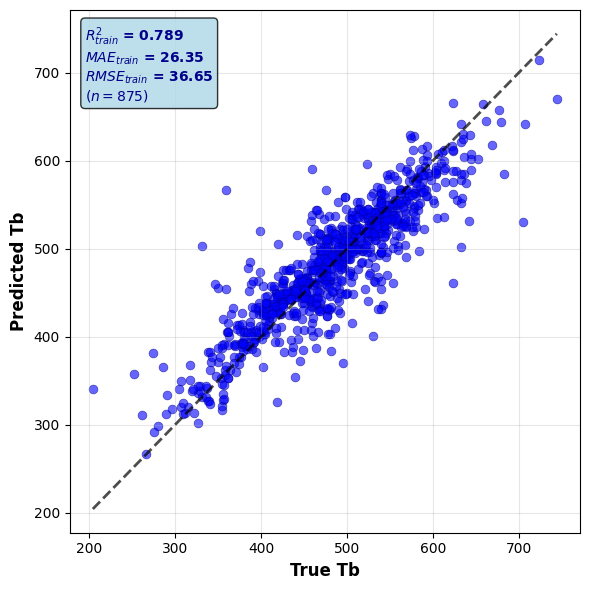

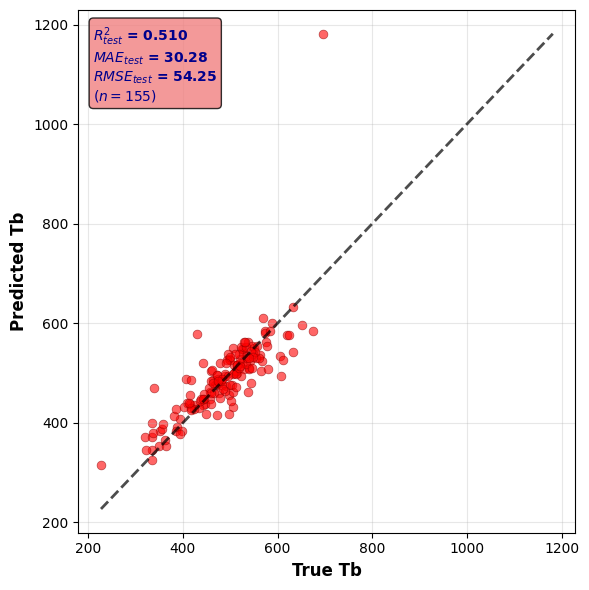

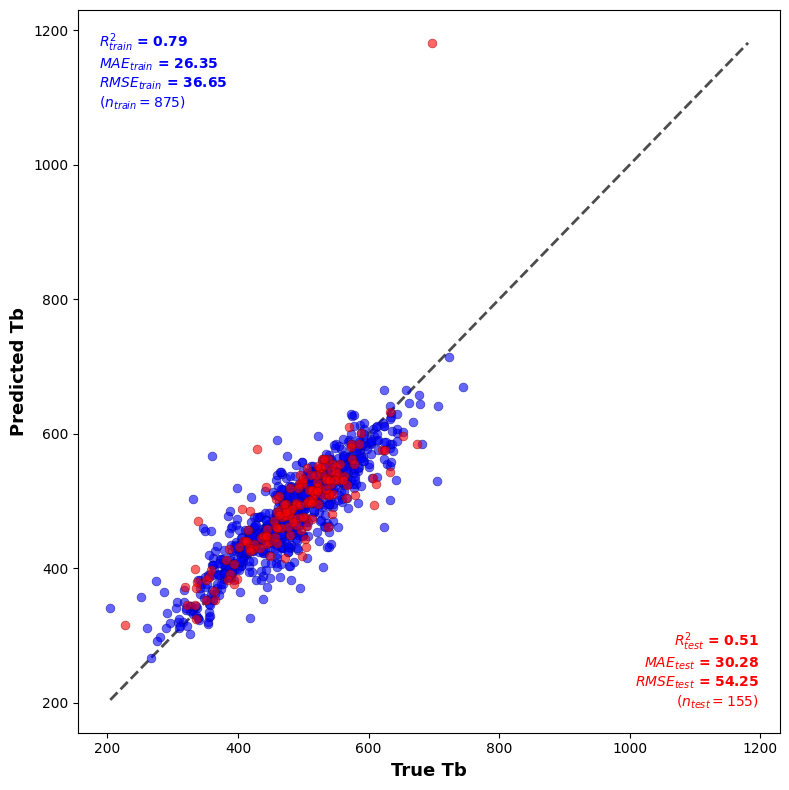


Results saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/Tb/

SUMMARY
property  test_r2  test_rmse         lml
      Tb   0.5103  54.250412 -629.666412

Summary saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/summary_results.csv

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 19min 12s, sys: 7.54 s, total: 19min 20s
Wall time: 12min 33s


In [ ]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['Tb']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 10

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")

# H_vap


######################################################################
STARTING: Hvap (1/1)
######################################################################

Processing: Hvap
Data: 75 samples, 2 features

Running 5-fold cross-validation...
CV Test R²: -18.443 ± 37.490
CV Test RMSE: 13.93 ± 16.80
Applying feature engineering...
Features after engineering: 4

Training GP (method 4, 25 restarts)...
LML: -29.8182, Condition: 3.19e+02

Results:
Train - R²: 0.998, RMSE: 0.34
Test  - R²: 0.916, RMSE: 2.18
Uncertainty calibration - Train: 0.428, Test: 0.606


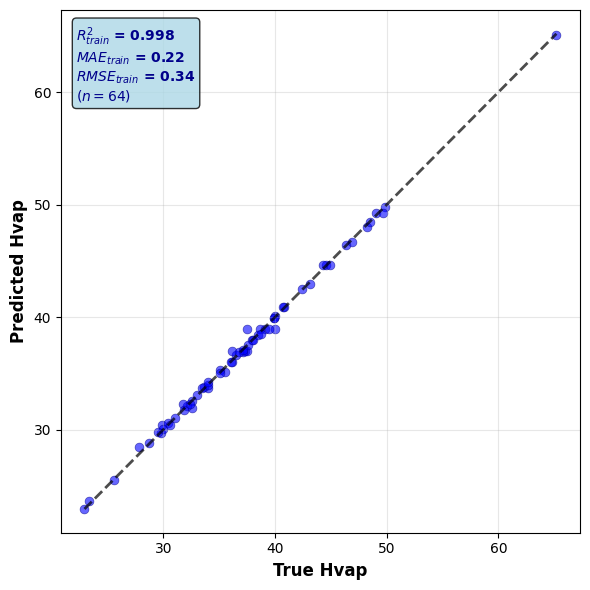

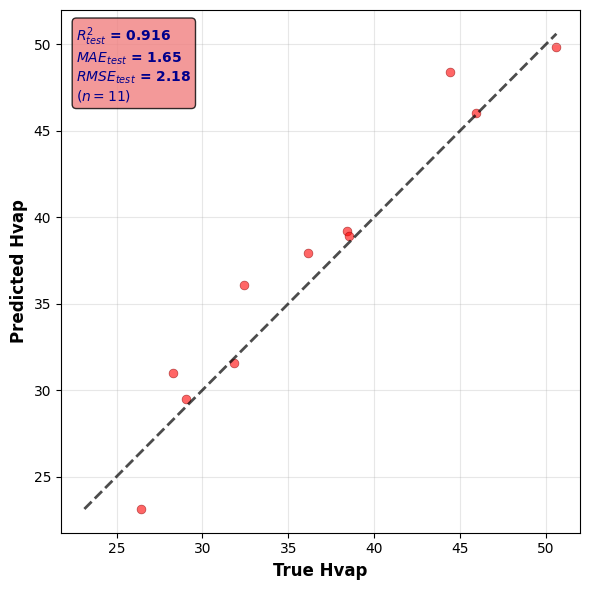

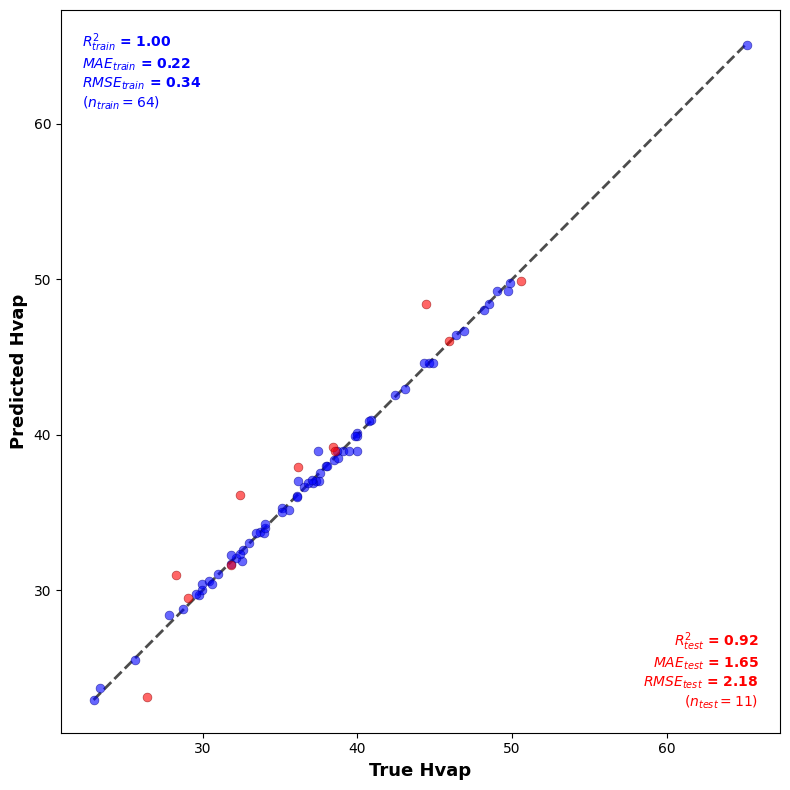


Results saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/Hvap/

SUMMARY
property  test_r2  test_rmse        lml
    Hvap 0.915716   2.182178 -29.818199

Summary saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/summary_results.csv

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 1min 53s, sys: 2.66 s, total: 1min 55s
Wall time: 1min 32s


In [ ]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['Hvap']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 25
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 5

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")

### Tm

In [11]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['Tm']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern12'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 25
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 5

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")


######################################################################
STARTING: Tm (1/1)
######################################################################

Processing: Tm
Data: 1939 samples, 2 features

Running 5-fold cross-validation...

ERROR processing Tm: GP optimization failed for all restarts

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 3min 20s, sys: 1.74 s, total: 3min 22s
Wall time: 2min 56s


Traceback (most recent call last):
  File "<timed exec>", line 47, in <module>
  File "/tmp/ipython-input-2325046949.py", line 643, in process_property
    cv_results = cross_validate(X, Y, config, method_number,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2325046949.py", line 393, in cross_validate
    model, _ = train_gp_model(X_train_n, Y_train_n, config,
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2325046949.py", line 287, in train_gp_model
    raise RuntimeError("GP optimization failed for all restarts")
RuntimeError: GP optimization failed for all restarts


# Pc, Vc


######################################################################
STARTING: Pc (1/2)
######################################################################

Processing: Pc
Data: 75 samples, 2 features

Running 5-fold cross-validation...
CV Test R²: 0.487 ± 0.504
CV Test RMSE: 7.32 ± 3.60
Applying feature engineering...
Features after engineering: 5

Training GP (method 4, 25 restarts)...
LML: -27.7570, Condition: 1.00e+00

Results:
Train - R²: 0.861, RMSE: 5.01
Test  - R²: 0.785, RMSE: 3.35
Uncertainty calibration - Train: 1.000, Test: 0.653


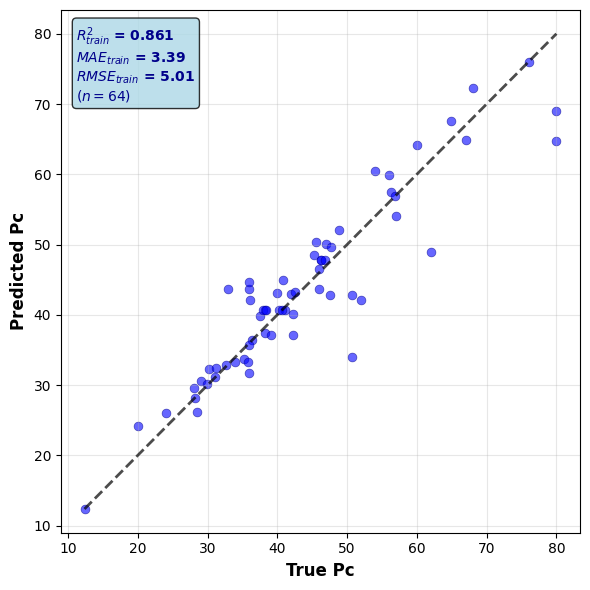

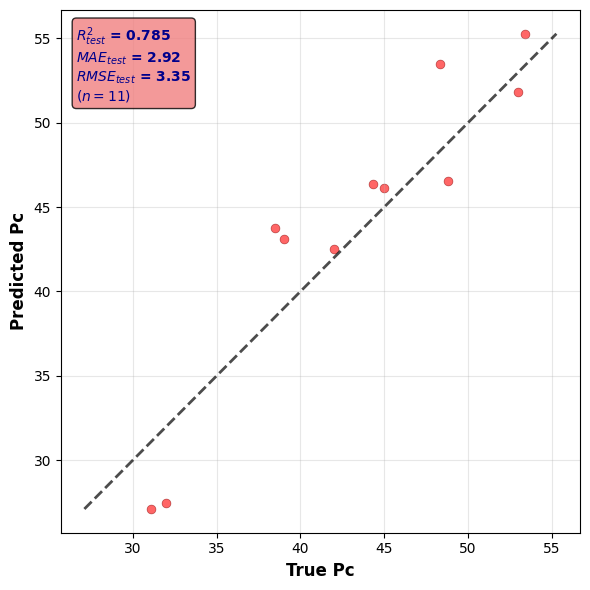

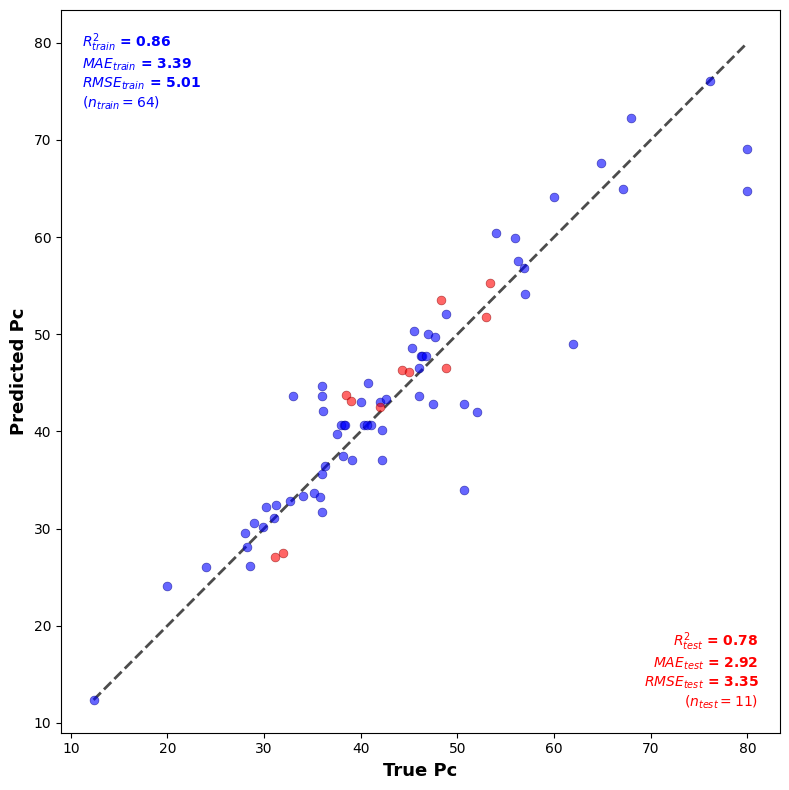


Results saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/Pc/

######################################################################
STARTING: Vc (2/2)
######################################################################

Processing: Vc
Data: 69 samples, 2 features

Running 5-fold cross-validation...
CV Test R²: 0.980 ± 0.007
CV Test RMSE: 20.95 ± 10.09
Applying feature engineering...
Features after engineering: 5

Training GP (method 4, 25 restarts)...
LML: 56.4138, Condition: 1.00e+00

Results:
Train - R²: 0.991, RMSE: 15.50
Test  - R²: 0.985, RMSE: 11.68
Uncertainty calibration - Train: 1.001, Test: 0.473


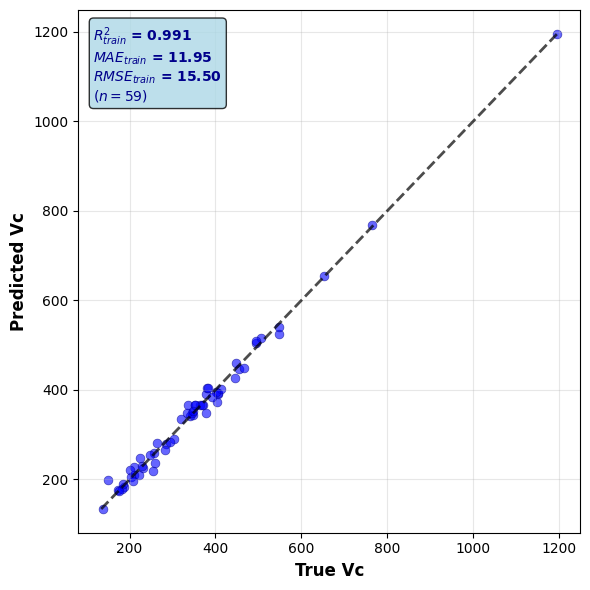

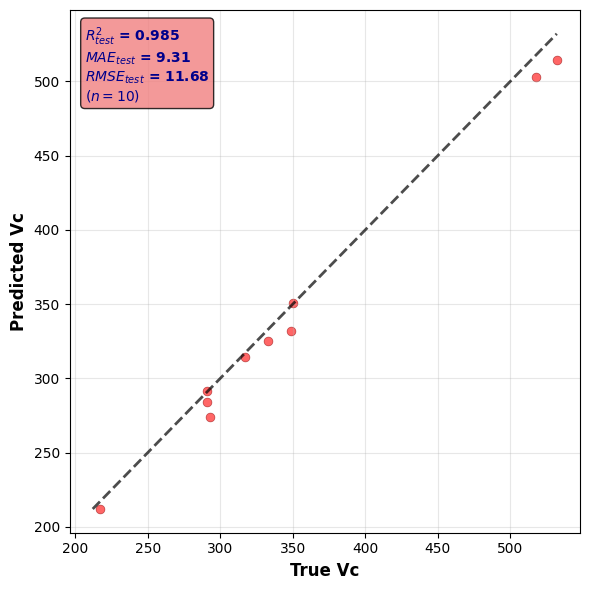

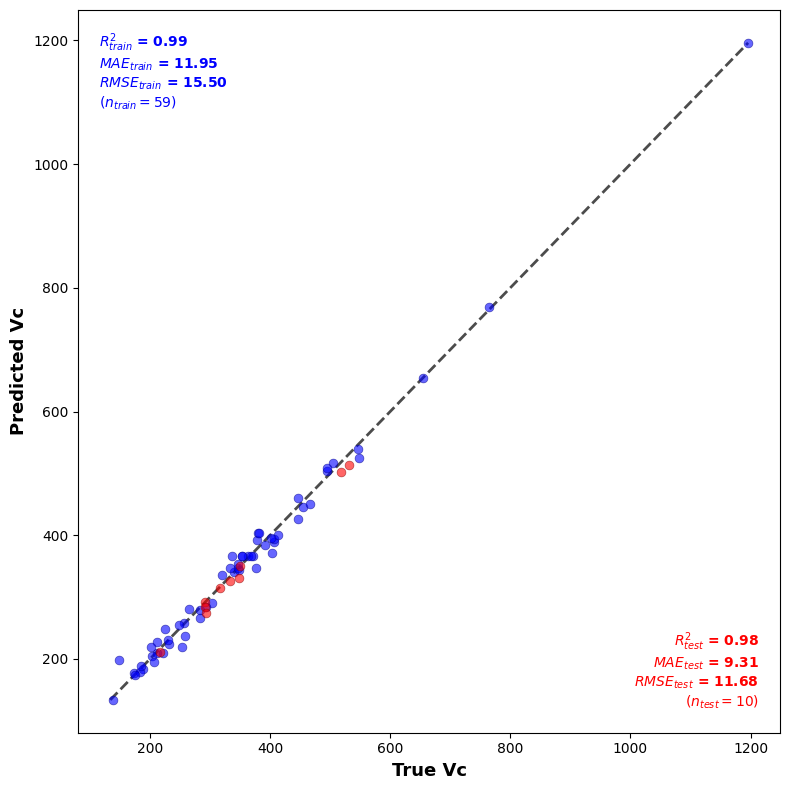


Results saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/Vc/

SUMMARY
property  test_r2  test_rmse        lml
      Pc 0.784695   3.354541 -27.756955
      Vc 0.984944  11.680473  56.413813

Summary saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/summary_results.csv

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 3min 41s, sys: 5.75 s, total: 3min 46s
Wall time: 3min 28s


In [ ]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['Pc', 'Vc']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 25
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 5

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")

### Tc

In [ ]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['Tc']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'BFGS'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 25
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 5

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")


######################################################################
STARTING: Tc (1/1)
######################################################################

Processing: Tc
Data: 75 samples, 2 features

Running 5-fold cross-validation...

ERROR processing Tc: GP optimization failed for all restarts

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 10.3 s, sys: 396 ms, total: 10.7 s
Wall time: 10.5 s


Traceback (most recent call last):
  File "<timed exec>", line 47, in <module>
  File "/tmp/ipython-input-114843285.py", line 643, in process_property
    cv_results = cross_validate(X, Y, config, method_number,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-114843285.py", line 393, in cross_validate
    model, _ = train_gp_model(X_train_n, Y_train_n, config,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-114843285.py", line 287, in train_gp_model
    raise RuntimeError("GP optimization failed for all restarts")
RuntimeError: GP optimization failed for all restarts


# logP

In [ ]:
%%time

if __name__ == "__main__":
    # Paths
    DATA_DIR = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'

    # Properties to process (CHANGE THIS - add/remove properties as needed)
    property_codes = ['logP']  # Options: 'Tb', 'Tc', 'Tm', 'Pc', 'Vc', 'Hvap', 'logP'

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 25
    seed = 42
    method_number = method_number

    # Additional options
    feature_engineering = True
    run_cv = True  # Set to True to run cross-validation
    n_cv_folds = 5

    # =============================================================================
    # RUN PROCESSING
    # =============================================================================

    # Create GP configuration
    gp_config = gpConfig_from_method(
        method_number=method_number,
        kernel=kernel,
        anisotropic=anisotropic,
        useWhiteKernel=useWhiteKernel,
        trainLikelihood=trainLikelihood,
        opt_method=opt_method
    )

    # Process each property
    results = []
    for prop_code in property_codes:
        print(f"\n{'#'*70}")
        print(f"STARTING: {prop_code} ({property_codes.index(prop_code)+1}/{len(property_codes)})")
        print(f"{'#'*70}")

        try:
            result = process_property(
                property_code=prop_code,
                config=gp_config,
                modelBuildingDataDir=modelBuildingDataDir,
                output_dir=outputDir,
                method_number=method_number,
                feature_engineering=feature_engineering,
                run_cv=run_cv,
                n_cv_folds=n_cv_folds,
                n_restarts=retrain_GP,
                seed=seed
            )
            results.append(result)

        except Exception as e:
            print(f"\nERROR processing {prop_code}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Summary
    if results:
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        summary_df = pd.DataFrame(results)
        print(summary_df[['property', 'test_r2', 'test_rmse', 'lml']].to_string(index=False))

        # Save summary
        summary_df.to_csv(f'{outputDir}summary_results.csv', index=False)
        print(f"\nSummary saved to: {outputDir}summary_results.csv")

    print(f"\n{'-'*70}")
    print("COMPLETE")
    print(f"{'-'*70}")


######################################################################
STARTING: logP (1/1)
######################################################################

Processing: logP
Data: 3463 samples, 2 features

Running 5-fold cross-validation...

ERROR processing logP: GP optimization failed for all restarts

----------------------------------------------------------------------
COMPLETE
----------------------------------------------------------------------
CPU times: user 11min 54s, sys: 3.77 s, total: 11min 58s
Wall time: 11min 59s


Traceback (most recent call last):
  File "<timed exec>", line 47, in <module>
  File "/tmp/ipython-input-114843285.py", line 643, in process_property
    cv_results = cross_validate(X, Y, config, method_number,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-114843285.py", line 393, in cross_validate
    model, _ = train_gp_model(X_train_n, Y_train_n, config,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-114843285.py", line 287, in train_gp_model
    raise RuntimeError("GP optimization failed for all restarts")
RuntimeError: GP optimization failed for all restarts


### GP method without outliers

In [ ]:
# -*- coding: utf-8 -*-
"""
Script to train a GP on physicochemical properties.
"""


import os
import warnings
import time

# Specific
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import gpflow
from gpflow.utilities import print_summary, set_trainable, deepcopy
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# =============================================================================
# Auxiliary Functions
# =============================================================================


def set_white_exp_95CI(code):
    """
    Sets the estimated average ~95% confidence interval on labels using the property code

    Parameters:
    code : string
        Property code

    Returns:
    exp_95CI : float
    """
    if code == 'Tb':
        exp_95CI = 10.0
    elif code == 'Tm':
        exp_95CI = 5.0
    elif code == 'Hvap':
        exp_95CI = 1.0
    elif code == 'Vc':
        exp_95CI = 25.0
    elif code == 'Tc':
        exp_95CI = 5.0
    elif code == 'Pc':
        exp_95CI = 30.0
    elif code == 'logP':
        exp_95CI = 1.0
    return exp_95CI



def gpConfig_from_method(method_number, code, kernel = 'RBF', anisotropic = True, useWhiteKernel = True, trainLikelihood = True, opt_method = 'BFGS'):
    """
    Creates a gpConfig dictionary based on the method number.

    Parameters:
    method_number : int
        Method number.

    Returns:
    gpConfig : dictionary
        Dictionary of GP configuration parameters.

    Note:
    method_number is used to define which type of gp model to use
    1: Y = GP(0, K(Mw, Y_gc))
    2: Y - Y_gc = GP(0, K(Mw))
    3: Y - Y_gc = GP(0, K(Mw, Y_gc))
    4: Y = GP(Y_gc, K(Mw, Y_gc))
    5: Y = GP(AMw + BY_gc + c, K(Mw, Y_gc))
    """
    gpConfig={'kernel': kernel,
           'useWhiteKernel':useWhiteKernel,
           'trainLikelihood':trainLikelihood,
           'opt_method':opt_method,
           'anisotropic':anisotropic}
    if method_number == 1:
        gpConfig['mean_function']='Zero'
        gpConfig['Name']='y_exp = GP(0, K(x1,x2))'
        gpConfig['SaveName']='model_1'
    if method_number == 2:
        gpConfig['mean_function']='Zero'
        gpConfig['Name']='y_exp = y_GC + GP(0, K(x1))'
        gpConfig['SaveName']='model_2'
    if method_number == 3:
        gpConfig['mean_function']='Constant'
        gpConfig['Name']='y_exp = GP(y_GC, K(x1,x2))'
        gpConfig['SaveName']='model_3'
    if method_number == 4:
        gpConfig['mean_function']='Linear'
        gpConfig['Name']='y_exp = GP(B@X, K(x1,x2))'
        gpConfig['SaveName']='model_4'
    else:
        if method_number not in [1 , 2, 3, 4]:
            raise ValueError('invalid method number input')
    return gpConfig


def get_gp_data(X, Y, method_number):
    """
    Gets X and Y data to train GP based on the method number

    Parameters:
    X : numpy array
        Features data.
    Y : numpy array
        Property data.
    method_number : int
        Method number

    Returns:
    X_gp : numpy array
        Features data to train GP.
    Y_gp: numpy array
        Data to train GP.
    Y_gc: numpy array
        Data from Joback method
    """
    if method_number == 2:
        X_gp = X[:,0].reshape(-1,1)
    else:
        X_gp = X
    if method_number == 2:
        Y_gp = Y - X[:,1]
    else:
        Y_gp = Y
    Y_gp = Y_gp.reshape(-1,1)
    Y_gc = X[:,1].reshape(-1,1)
    return X_gp, Y_gp, Y_gc


def discrepancy_to_property(method_number, y_pred, y_gc, idx):
    """
    Adds discrepancy to property based on the method number
    Parameters:
    method_number : int
        Method number
    y_pred : numpy array
        GP predicted output
    y_gc : numpy array
        Predicted GC method results
    idx : np.array
        Index of the y_gc to be added to y_pred

    Returns:
    y_prop : numpy array
        Predicted property value
    """
    if method_number == 2:
        y_prop = y_pred + y_gc[idx.flatten(),:]
    else:
        y_prop = y_pred
    return y_prop

def stratifyvector(Y):
    """
    Creates a stratified vector based on the label data Y

    Parameters:
    Y : numpy array
        label data
    Returns:
    stratifyVector : numpy array
        Stratified vector
    """
    # Iterate over number of bins, trying to find the larger number of bins that
    # guarantees at least 5 values per bin
    for n in range(1,100):
        # Bin Y using n bins
        stratifyVector=pd.cut(Y,n,labels=False)
        # Define isValid (all bins have at least 5 values)
        isValid=True
        # Check that all bins have at least 5 values
        for k in range(n):
            if np.count_nonzero(stratifyVector==k)<5:
                isValid=False
        #If isValid is false, n is too large; nBins must be the previous iteration
        if not isValid:
            nBins=n-1
            break
    # Generate vector for stratified splitting based on labels
    stratifyVector=pd.cut(Y,nBins,labels=False)
    return stratifyVector

def normalize(inputArray,skScaler=None,method='Standardization',reverse=False):
    """
    normalize() normalizes (or unnormalizes) inputArray using the method
    specified and the skScaler provided.

    Parameters
    ----------
    inputArray : numpy array
        Array to be normalized. If dim>1, array is normalized column-wise.
    skScaler : scikit-learn preprocessing object or None
        Scikit-learn preprocessing object previosly fitted to data. If None,
        the object is fitted to inputArray.
        Default: None
    method : string, optional
        Normalization method to be used.
        Methods available:
            . Standardization - classic standardization, (x-mean(x))/std(x)
            . MinMax - scale to range (0,1)
            . LogStand - standardization on the log of the variable,
                         (log(x)-mean(log(x)))/std(log(x))
            . Log+bStand - standardization on the log of variables that can be
                           zero; uses a small buffer,
                           (log(x+b)-mean(log(x+b)))/std(log(x+b))
        Default: 'Standardization'
    reverse : bool
        Whether  to normalize (False) or unnormalize (True) inputArray.
        Defalt: False

    Returns
    -------
    inputArray : numpy array
        Normalized (or unnormalized) version of inputArray.
    skScaler : scikit-learn preprocessing object
        Scikit-learn preprocessing object fitted to inputArray. It is the same
        as the inputted skScaler, if it was provided.

    """
    # If inputArray is a labels vector of size (N,), reshape to (N,1)
    if inputArray.ndim==1:
        inputArray=inputArray.reshape((-1,1))
        warnings.warn('Input to normalize() was of shape (N,). It was assumed'\
                      +' to be a column array and converted to a (N,1) shape.')
    # If skScaler is None, train for the first time
    if method == 'None':
        inputArray=inputArray
        skScaler = None
    else:
        if skScaler is None:
            # Check method
            if method=='Standardization' or method=='MinMax': aux=inputArray
            elif method=='LogStand': aux=np.log(inputArray)
            elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
            else: raise ValueError('Could not recognize method in normalize().')
            if method!='MinMax':
                skScaler=preprocessing.StandardScaler().fit(aux)
            else:
                skScaler=preprocessing.MinMaxScaler().fit(aux)
        # Do main operation (normalize or unnormalize)
        if reverse:
            # Rescale the data back to its original distribution
            inputArray=skScaler.inverse_transform(inputArray)
            # Check method
            if method=='LogStand': inputArray=np.exp(inputArray)
            elif method=='Log+bStand': inputArray=np.exp(inputArray)-10**-3
        elif not reverse:
            # Check method
            if method=='Standardization' or method=='MinMax': aux=inputArray
            elif method=='LogStand': aux=np.log(inputArray)
            elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
            else: raise ValueError('Could not recognize method in normalize().')
            inputArray=skScaler.transform(aux)
    # Return
    return inputArray,skScaler



# Build GPR model function with bounded hyperparameters
def build_model_with_bounded_params(X, Y, kern, low, high, \
                                    high_alpha, init_val1, init_val2, init_val3, \
                                    useWhite, trainLikelihood, anisotropic, typeMeanFunc):
    """
    build_model_with_bounded_params(*) creates a GP model object with bounded hyperparameters and initial
    values

    Parameters
    ----------
    X : numpy array
        Feature data
    Y : numpy array
        Label data
    low : float
        lower bound on all hyperparameters
    high : float
        upper bound on all hyperparameters except alpha for the RQ kernel
    high_alpha : float
        upper bound on alpha hyperparameter for the RQ kernel
    init_val1 : float
        initial values for first length scale and alpha parameter
    init_val2 : float
        initial values for second length scale for anisotropic kernels
        for isotropic kernels, only one initial value (init_val1) is used
    init_val1 : float
        initial values for variance or scale hyperparameter of kernel 1 (not Whitenoise kernel)

    Returns
    -------
    model : Gpflow model object
        GP model object with bounded hyperparameters and initial values

    """

    low = tf.cast(low, dtype=tf.float64)
    high = tf.cast(high, dtype=tf.float64)
    high_alpha = tf.cast(high_alpha, dtype=tf.float64)
    init_val1 = tf.cast(init_val1, dtype=tf.float64)
    init_val2 = tf.cast(init_val2, dtype=tf.float64)
    init_val3 = tf.cast(init_val3, dtype=tf.float64)
    if anisotropic == True:
        lsc = gpflow.Parameter([init_val1, init_val2], transform=tfb.Sigmoid(low , high), dtype=tf.float64)
    else:
        lsc = gpflow.Parameter(init_val1, transform=tfb.Sigmoid(low , high), dtype=tf.float64)
    alf = gpflow.Parameter(init_val1, transform=tfb.Sigmoid(low , high_alpha), dtype=tf.float64)
    var = gpflow.Parameter(init_val3, transform=tfb.Sigmoid(low , high), dtype=tf.float64)
    if kern == "RQ":
        kernel_ = gpflow.kernels.RationalQuadratic()
        kernel_.alpha = alf
        kernel_.lengthscales = lsc
        kernel_.variance = var
    elif kern == "RBF":
        kernel_ = gpflow.kernels.RBF()
        kernel_.lengthscales = lsc
        kernel_.variance = var
    elif kern == "Matern12":
        kernel_ = gpflow.kernels.Matern12()
        kernel_.lengthscales = lsc
        kernel_.variance = var
    elif kern == "Matern32":
        kernel_ = gpflow.kernels.Matern32()
        kernel_.lengthscales = lsc
        kernel_.variance = var
    elif kern == "Matern52":
        kernel_ = gpflow.kernels.Matern52()
        kernel_.lengthscales = lsc
        kernel_.variance = var
    if useWhite == True:
        #white_var = np.array(np.random.uniform(0.05, 1.0))
        final_kernel = kernel_+gpflow.kernels.White(variance=1.0)
    else:
        final_kernel = kernel_

    if typeMeanFunc == 'Zero':
        mf = None
    if typeMeanFunc == 'Constant':
        #If constant value is selected but no value is given, default to zero mean
        mf_val = np.array([0,1]).reshape(-1,1)
        mf = gpflow.functions.Linear(mf_val)
    if typeMeanFunc == 'Linear':
        A = np.ones((X.shape[1],1))
        mf = gpflow.functions.Linear(A)
    model_ = gpflow.models.GPR(data=(X, Y), kernel=final_kernel, mean_function=mf, noise_variance=10**-5)
    if typeMeanFunc == 'Constant':
        gpflow.set_trainable(model_.mean_function.A, False)
        gpflow.set_trainable(model_.mean_function.b, False)
    gpflow.utilities.set_trainable(model_.likelihood.variance,trainLikelihood)
    model = model_
    return model



def buildGP(X_Train, Y_Train, gpConfig, code, featurenorm, retrain_count):
    """
    buildGP() builds and fits a GP model using the training data provided.

    Parameters
    ----------
    X_Train : numpy array (N,K)
        Training features, where N is the number of data points and K is the
        number of independent features
    Y_Train : numpy array (N,1)
        Training labels (e.g., property of a given molecule).
    gpConfig : dictionary, optional
        Dictionary containing the configuration of the GP. If a key is not
        present in the dictionary, its default value is used.
        Keys:
            . kernel : string
                Kernel to be used. One of:
                    . 'RBF' - gpflow.kernels.RBF()
                    . 'RQ' - gpflow.kernels.RationalQuadratic()
                    . 'Matern12' - gpflow.kernels.Matern12()
                    . 'Matern32' - gpflow.kernels.Matern32()
                    . 'Matern52' - gpflow.kernels.Matern52()
                The default is 'RQ'.
            . useWhiteKernel : boolean
                Whether to use a White kernel (gpflow.kernels.White).
                The default is True.
            . trainLikelihood : boolean
                Whether to treat the variance of the likelihood of the modeal
                as a trainable (or fitting) parameter. If False, this value is
                fixed at 10^-5.
                The default is True.
        The default is {}.
    sc_y_scale : Scikit learn standard scaler object
        standard scaler fitted on label training data
    retrain_count : int
        Current GP retrain number

    """
    # Unpack gpConfig
    kernel=gpConfig.get('kernel','RQ')
    useWhiteKernel=gpConfig.get('useWhiteKernel','True')
    trainLikelihood=gpConfig.get('trainLikelihood','True')
    typeMeanFunc=gpConfig.get('mean_function','Zero')
    opt_method=gpConfig.get('opt_method','L-BFGS-B')
    anisotropy=gpConfig.get('anisotropic','False')

    seed_ = int(retrain_count) * 100
    np.random.seed(seed_)
    tf.random.set_seed(seed_)

    if retrain_count == 0:
        init_val1 = 1
        init_val2 = 1
        init_val3 = 1
    else:
        init_val1 = np.array(np.random.uniform(0, 100))
        init_val2 = np.array(np.random.uniform(0, 100))
        init_val3 = np.array(np.random.lognormal(0, 1.0))

    model = build_model_with_bounded_params(X_Train, Y_Train, kernel, 0.00001, 100, 5000, init_val1, \
                            init_val2, init_val3, useWhiteKernel, trainLikelihood, anisotropy, typeMeanFunc)
    model_pretrain = deepcopy(model)
    # print(gpflow.utilities.print_summary(model))
    condition_number = np.linalg.cond(model.kernel(X_Train))
    # Build optimizer
    optimizer=gpflow.optimizers.Scipy()
    # Fit GP to training data
    aux=optimizer.minimize(model.training_loss,
                           model.trainable_variables,
                           options={'maxiter':10**9},
                           method=opt_method)
    obj_func = model.training_loss()
    if aux.success:
        opt_success = True
    else:
        opt_success = False

    return model, aux, condition_number, obj_func, opt_success, retrain_count, model_pretrain



def train_gp(X_Train, Y_Train, gpConfig, code, sc_y, featurenorm, retrain_GP, retrain_count):
    """
    Trains the GP given training data.


    """

    # Train the model multiple times and keep track of the model with the lowest minimum training loss
    best_minimum_loss = float('inf')
    best_model = None
    best_model_pretrain = None
    best_model_success = False
    best_condition_num = float('inf')
    args = (X_Train, Y_Train, gpConfig)

    retrain_GP = int(retrain_GP)
    retrain_count = retrain_count
    for i in range(retrain_GP):
        model, aux, condition_number, obj_func, opt_success, retrain_count, model_pretrain = \
            buildGP(X_Train, Y_Train, gpConfig, code, featurenorm, retrain_count)
        print(f"training_loss = {obj_func}")
        print(f"condition_number = {condition_number}")
        retrain_count += 1
        if best_minimum_loss > obj_func and opt_success==True:
            best_minimum_loss = obj_func
            best_model = model
            best_model_pretrain = model_pretrain
            best_model_success = opt_success
            best_condition_num = condition_number
    if best_model_success == False:
        warnings.warn('GP optimizer failed to converge with retrains')

    #Put hyperparameters in a list
    trained_hyperparams = gpflow.utilities.read_values(best_model)

    if sc_y != None:
        sc_y_scale = sc_y.scale_
    else:
        sc_y_scale = None

    return best_model,best_minimum_loss,best_model_success,best_condition_num,trained_hyperparams,best_model_pretrain,sc_y_scale


def gpPredict(model,X):
    """
    gpPredict() returns the prediction and variance of the GP model
    on the X data provided.

    Parameters
    ----------
    model : gpflow.models.gpr.GPR object
        GP model.
    X : numpy array (N,K)
        Training features, where N is the number of data points and K is the
        number of independent features (e.g., sigma profile bins).

    Returns
    -------
    Y : numpy array (N,1)
        GP predictions.
    STD : numpy array (N,1)
        GP standard deviations.

    """
    # Do GP prediction, obtaining mean and variance
    GP_Mean,GP_Var=model.predict_f(X)
    # Convert to numpy
    GP_Mean=GP_Mean.numpy()
    GP_Var=GP_Var.numpy()
    # Prepare outputs
    Y=GP_Mean
    VAR=GP_Var
    # Output
    return Y,VAR




def count_outside_95(Y_Train, Y_Test, Y_Train_Pred, Y_Test_Pred, Y_Train_CI, Y_Test_CI):
    """
    count_outside_95() finds the number and fraction of predicted data that are outside the predicted 95%
        confidence intervals from the true values

    Parameters:
    Y_Train_CI : numpy array
        Absolute values of the 95% confidence interval on the predictions on training set
    Y_Test_CI : numpy array
        Absolute values of the 95% confidence interval on the predictions on testing set

    """
    out_95_train = []
    out_95_test = []
    for index, value in enumerate(Y_Train):
        if np.abs(value - Y_Train_Pred[index]) > Y_Train_CI[index]:
            out_95_train.append(index)
    num_out95_train = len(out_95_train)
    frac_out95_train = num_out95_train/len(Y_Train)
    for index, value in enumerate(Y_Test):
        if np.abs(value - Y_Test_Pred[index]) > Y_Test_CI[index]:
            out_95_test.append(index)
    num_out95_test = len(out_95_test)
    frac_out95_test = num_out95_test/len(Y_Test)

    return num_out95_train, frac_out95_train, num_out95_test, frac_out95_test


# =============================================================================
# Statistical Metrics and Plotting Functions
# =============================================================================
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive statistical metrics"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # MAPE and MPE with zero-division protection
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        mpe = np.mean((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100
    else:
        mape = np.inf
        mpe = np.inf

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'MPE': mpe}

def calculate_improvement(train_metrics, test_metrics):
    """Calculate improvement metrics (positive values indicate overfitting)"""
    improvement = {}

    # For R2: higher is better, so improvement = train - test
    improvement['R2'] = train_metrics['R2'] - test_metrics['R2']

    # For error metrics: lower is better, so improvement = test - train
    improvement['MAE'] = test_metrics['MAE'] - train_metrics['MAE']
    improvement['RMSE'] = test_metrics['RMSE'] - train_metrics['RMSE']
    improvement['MAPE'] = test_metrics['MAPE'] - train_metrics['MAPE']
    improvement['MPE'] = test_metrics['MPE'] - train_metrics['MPE']

    return improvement

def plot_predictions(Y_train_true, Y_train_pred, Y_test_true, Y_test_pred,
                    Y_train_ci, Y_test_ci, property_name, save_path):
    """Create side-by-side parity plots: Train, Test, and Combined"""

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'GP Predictions for {property_name}', fontsize=16, fontweight='bold')

    # Flatten arrays
    y_train_true_flat = Y_train_true.flatten()
    y_train_pred_flat = Y_train_pred.flatten()
    y_train_ci_flat = Y_train_ci.flatten()
    y_test_true_flat = Y_test_true.flatten()
    y_test_pred_flat = Y_test_pred.flatten()
    y_test_ci_flat = Y_test_ci.flatten()

    # Calculate metrics
    train_metrics = calculate_metrics(y_train_true_flat, y_train_pred_flat)
    test_metrics = calculate_metrics(y_test_true_flat, y_test_pred_flat)

    # Combined data for the third plot
    y_combined_true = np.concatenate([y_train_true_flat, y_test_true_flat])
    y_combined_pred = np.concatenate([y_train_pred_flat, y_test_pred_flat])
    y_combined_ci = np.concatenate([y_train_ci_flat, y_test_ci_flat])
    combined_metrics = calculate_metrics(y_combined_true, y_combined_pred)

    # Plot 1: Training Set
    ax1 = axes[0]
    # Changed: True on x-axis, Predicted on y-axis
    ax1.scatter(y_train_true_flat, y_train_pred_flat, alpha=0.6, s=30, color='blue')
    ax1.errorbar(y_train_true_flat, y_train_pred_flat, yerr=y_train_ci_flat,
                fmt='none', alpha=0.3, color='blue')

    min_val = min(y_train_true_flat.min(), y_train_pred_flat.min())
    max_val = max(y_train_true_flat.max(), y_train_pred_flat.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=2)

    ax1.set_title(f'Training Set (n={len(y_train_true_flat)})\n'
                  f'R² = {train_metrics["R2"]:.3f}, RMSE = {train_metrics["RMSE"]:.2f}\n'
                  f'MAE = {train_metrics["MAE"]:.2f}, MAPE = {train_metrics["MAPE"]:.1f}%')
    ax1.set_xlabel(f'True {property_name}')        # Changed: True on x-axis
    ax1.set_ylabel(f'Predicted {property_name}')   # Changed: Predicted on y-axis
    ax1.grid(True, alpha=0.3)

    # Plot 2: Test Set
    ax2 = axes[1]
    # Changed: True on x-axis, Predicted on y-axis
    ax2.scatter(y_test_true_flat, y_test_pred_flat, alpha=0.6, s=30, color='red')
    ax2.errorbar(y_test_true_flat, y_test_pred_flat, yerr=y_test_ci_flat,
                fmt='none', alpha=0.3, color='red')

    min_val = min(y_test_true_flat.min(), y_test_pred_flat.min())
    max_val = max(y_test_true_flat.max(), y_test_pred_flat.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=2)

    ax2.set_title(f'Test Set (n={len(y_test_true_flat)})\n'
                  f'R² = {test_metrics["R2"]:.3f}, RMSE = {test_metrics["RMSE"]:.2f}\n'
                  f'MAE = {test_metrics["MAE"]:.2f}, MAPE = {test_metrics["MAPE"]:.1f}%')
    ax2.set_xlabel(f'True {property_name}')        # Changed: True on x-axis
    ax2.set_ylabel(f'Predicted {property_name}')   # Changed: Predicted on y-axis
    ax2.grid(True, alpha=0.3)

    # Plot 3: Combined Train + Test Set
    ax3 = axes[2]
    # Changed: True on x-axis, Predicted on y-axis
    ax3.scatter(y_train_true_flat, y_train_pred_flat, alpha=0.5, s=25, color='blue', label='Training')
    ax3.scatter(y_test_true_flat, y_test_pred_flat, alpha=0.5, s=25, color='red', label='Test')
    ax3.errorbar(y_combined_true, y_combined_pred, yerr=y_combined_ci,
                fmt='none', alpha=0.2, color='gray')

    min_val = min(y_combined_true.min(), y_combined_pred.min())
    max_val = max(y_combined_true.max(), y_combined_pred.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=2)

    ax3.set_title(f'Combined (n={len(y_combined_true)})\n'
                  f'R² = {combined_metrics["R2"]:.3f}, RMSE = {combined_metrics["RMSE"]:.2f}\n'
                  f'MAE = {combined_metrics["MAE"]:.2f}, MAPE = {combined_metrics["MAPE"]:.1f}%')
    ax3.set_xlabel(f'True {property_name}')        # Changed: True on x-axis
    ax3.set_ylabel(f'Predicted {property_name}')   # Changed: Predicted on y-axis
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/{property_name}_GP_results.png", dpi=300, bbox_inches='tight')
    plt.show()

    return train_metrics, test_metrics, combined_metrics



# =============================================================================
# Outlier Detection and Removal Functions
# =============================================================================
def detect_outliers_iqr(data, multiplier=1.5):
    """
    Detect outliers using Interquartile Range (IQR) method

    Parameters:
    data : numpy array
        1D array of data values
    multiplier : float
        IQR multiplier (1.5 is standard, 3.0 is more conservative)

    Returns:
    outlier_mask : numpy array
        Boolean mask where True indicates outlier
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outlier_mask = (data < lower_bound) | (data > upper_bound)
    return outlier_mask

def detect_outliers_zscore(data, threshold=3.0):
    """
    Detect outliers using Z-score method

    Parameters:
    data : numpy array
        1D array of data values
    threshold : float
        Z-score threshold (3.0 is standard)

    Returns:
    outlier_mask : numpy array
        Boolean mask where True indicates outlier
    """
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    outlier_mask = z_scores > threshold
    return outlier_mask

def detect_outliers_modified_zscore(data, threshold=3.5):
    """
    Detect outliers using Modified Z-score method (more robust)

    Parameters:
    data : numpy array
        1D array of data values
    threshold : float
        Modified Z-score threshold (3.5 is standard)

    Returns:
    outlier_mask : numpy array
        Boolean mask where True indicates outlier
    """
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    outlier_mask = np.abs(modified_z_scores) > threshold
    return outlier_mask

def remove_outliers(X, Y, method='iqr', threshold=1.5, verbose=True):
    """
    Remove outliers from the dataset based on target variable Y

    Parameters:
    X : numpy array
        Feature matrix
    Y : numpy array
        Target values
    method : str
        Outlier detection method ('iqr', 'zscore', 'modified_zscore')
    threshold : float
        Threshold parameter for outlier detection
    verbose : bool
        Whether to print outlier removal statistics

    Returns:
    X_clean : numpy array
        Feature matrix with outliers removed
    Y_clean : numpy array
        Target values with outliers removed
    outlier_info : dict
        Information about outlier removal
    """
    Y_flat = Y.flatten()

    # Detect outliers
    if method == 'iqr':
        outlier_mask = detect_outliers_iqr(Y_flat, multiplier=threshold)
    elif method == 'zscore':
        outlier_mask = detect_outliers_zscore(Y_flat, threshold=threshold)
    elif method == 'modified_zscore':
        outlier_mask = detect_outliers_modified_zscore(Y_flat, threshold=threshold)
    else:
        raise ValueError(f"Unknown outlier detection method: {method}")

    # Create clean datasets
    clean_mask = ~outlier_mask
    X_clean = X[clean_mask]
    Y_clean = Y[clean_mask]

    # Calculate statistics
    n_original = len(Y_flat)
    n_outliers = np.sum(outlier_mask)
    n_clean = len(Y_clean)
    outlier_percentage = (n_outliers / n_original) * 100

    outlier_info = {
        'method': method,
        'threshold': threshold,
        'n_original': n_original,
        'n_outliers': n_outliers,
        'n_clean': n_clean,
        'outlier_percentage': outlier_percentage,
        'outlier_indices': np.where(outlier_mask)[0],
        'outlier_values': Y_flat[outlier_mask]
    }

    if verbose:
        print(f"Outlier removal ({method}, threshold={threshold}):")
        print(f"  Original samples: {n_original}")
        print(f"  Outliers detected: {n_outliers} ({outlier_percentage:.1f}%)")
        print(f"  Clean samples: {n_clean}")
        if n_outliers > 0:
            print(f"  Outlier range: [{np.min(Y_flat[outlier_mask]):.2f}, {np.max(Y_flat[outlier_mask]):.2f}]")

    return X_clean, Y_clean, outlier_info

def process_single_property(code, kernel, anisotropic, opt_method, useWhiteKernel,
                          trainLikelihood, retrain_GP, method_number, outputDir,
                          modelBuildingDataDir, seed=42,
                          remove_outliers_flag=True, outlier_method='iqr', outlier_threshold=1.5):
    """
    Process a single property code with optional outlier removal

    Parameters:
    -----------
    code : str
        Property code (e.g., 'Tb', 'Tm', etc.)
    kernel : str
        Kernel type for GP
    anisotropic : bool
        Whether to use anisotropic kernel
    opt_method : str
        Optimization method
    useWhiteKernel : bool
        Whether to use white noise kernel
    trainLikelihood : bool
        Whether to train likelihood variance
    retrain_GP : int
        Number of GP retraining attempts
    method_number : int
        Method number for GP configuration
    outputDir : str
        Output directory path
    modelBuildingDataDir : str
        Model building data directory path
    seed : int
        Random seed for reproducibility
    remove_outliers_flag : bool
        Whether to remove outliers before training
    outlier_method : str
        Outlier detection method ('iqr', 'zscore', 'modified_zscore')
    outlier_threshold : float
        Threshold for outlier detection

    Returns:
    --------
    dict or None
        Results summary dictionary or None if processing failed
    """

    print(f"\n{'='*80}")
    print(f"PROCESSING PROPERTY: {code}")
    print(f"{'='*80}")

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Define normalization methods
    if method_number == 2:
        featureNorm, labelNorm = 'None', 'None'
    else:
        featureNorm, labelNorm = 'Standardization', 'Standardization'

    # GP Configuration
    gpConfig = gpConfig_from_method(method_number, code, kernel, anisotropic, useWhiteKernel, trainLikelihood, opt_method)

    try:
        # =============================================================================
        # Data Loading
        # =============================================================================
        data_file = f"{modelBuildingDataDir}{code}_prediction_data_fcl_with_N.csv"
        if not os.path.exists(data_file):
            print(f"Warning: Data file not found for {code}: {data_file}")
            return None

        db = pd.read_csv(data_file)
        print(f"Original data shape: {db.shape}")
        # Only drop rows where feature columns (2:-1) or target column (-1) have NaN
        feature_target_cols = db.columns[2:]  # Features + target columns
        db = db.dropna(subset=feature_target_cols)
        print(f"After removing rows with NaN in features/target: {db.shape}")
        X_original = db.iloc[:,2:-1].copy().to_numpy('float')
        data_names = db.columns.tolist()[2:]
        Y_original = db.iloc[:,-1].copy().to_numpy('float')
        Y_original = Y_original.reshape(-1,1)

        print(f"Loaded data for {code}: {X_original.shape[0]} samples, {X_original.shape[1]} features")

        # Store original data info
        n_original = len(Y_original)

        # =============================================================================
        # Outlier Detection and Removal
        # =============================================================================
        outlier_info = None
        if remove_outliers_flag:
            print(f"\nApplying outlier removal using {outlier_method} method (threshold={outlier_threshold})...")

            # Apply outlier removal
            X_clean, Y_clean, outlier_info = remove_outliers(
                X_original, Y_original,
                method=outlier_method,
                threshold=outlier_threshold,
                verbose=True
            )

            # Update dataframe to reflect outlier removal
            clean_mask = ~detect_outliers_iqr(Y_original.flatten(), multiplier=outlier_threshold) if outlier_method == 'iqr' else \
                        ~detect_outliers_zscore(Y_original.flatten(), threshold=outlier_threshold) if outlier_method == 'zscore' else \
                        ~detect_outliers_modified_zscore(Y_original.flatten(), threshold=outlier_threshold)

            db_clean = db[clean_mask].reset_index(drop=True)

            # Use cleaned data
            X = X_clean
            Y = Y_clean
            db = db_clean

            print(f"After outlier removal: {X.shape[0]} samples remaining")

        else:
            print(f"Outlier removal disabled - using all {n_original} samples")
            X = X_original
            Y = Y_original
            outlier_info = {
                'method': 'None',
                'threshold': 'N/A',
                'n_original': n_original,
                'n_outliers': 0,
                'n_clean': n_original,
                'outlier_percentage': 0.0,
                'outlier_indices': [],
                'outlier_values': []
            }

        # Extract additional variables from cleaned data
        Y_gc = X[:,-1].reshape(-1,1)
        MW = X[:,-2].reshape(-1,1)

        # =============================================================================
        # Stratified Train-Test Split
        # =============================================================================
        X_data = db.iloc[:,2:-1].copy()
        num_rows_X = X_data.shape[0]
        y_data_dum = (np.ones((num_rows_X, 2))).astype(int)
        indices = np.arange(X_data.shape[0])
        y_stratify = np.column_stack((indices, y_data_dum))
        X_stratify = X_data.values

        X_ = np.array(y_stratify)
        y_ = np.array(X_stratify)
        y_strat = y_
        X_strat = X_

        np.random.seed(seed)
        X_Train_0, y_Train_0, X_valTest_0, y_valTest_0 = iterative_train_test_split(X_strat, y_strat, test_size = 0.2)

        train_indices = (X_Train_0[:,0]).astype(int)
        test_indices = (X_valTest_0[:,0]).astype(int)

        trn_idx = train_indices
        test_idx = test_indices

        X_Train_0 = X[trn_idx, :]
        X_Test_0 = X[test_idx, :]
        Y_Train_0 = Y[trn_idx, :]
        Y_Test_0 = Y[test_idx, :]

        # =============================================================================
        # Prepare GP Data Based on Method Number
        # =============================================================================
        X_Train, Y_Train, Y_gc_Train = get_gp_data(X_Train_0, Y_Train_0[:,-1], method_number)
        X_Test, Y_Test, Y_gc_Test = get_gp_data(X_Test_0, Y_Test_0[:,-1], method_number)

        train_data = np.concatenate((X_Train, Y_Train), axis = 1)
        test_data = np.concatenate((X_Test, Y_Test), axis = 1)

        if method_number == 2:
            data_names =  data_names[:1] + [data_names[-1] + " Discrepancy"]

        train_df = pd.DataFrame(train_data, columns = data_names)
        test_df = pd.DataFrame(test_data, columns = data_names)

        # =============================================================================
        # Create Output Directory and Save Data
        # =============================================================================
        property_outputDir = f"{outputDir}{code}/{gpConfig['SaveName']}"
        print(f"Output directory: {property_outputDir}")
        os.makedirs(property_outputDir, exist_ok = True)

        train_df.to_csv(f"{property_outputDir}/train_data.csv", index= False)
        test_df.to_csv(f"{property_outputDir}/test_data.csv", index= False)

        # =============================================================================
        # Data Normalization
        # =============================================================================
        X_Train_N = X_Train.copy()
        X_Test_N = X_Test.copy()
        Y_Train_N = Y_Train.copy()
        Y_gc_Train_N = Y_gc_Train.copy()

        if featureNorm is not None:
            X_Train_N, skScaler_X = normalize(X_Train, method=featureNorm)
            X_Test_N, __ = normalize(X_Test, method=featureNorm, skScaler=skScaler_X)
        else:
            skScaler_X = None

        if labelNorm is not None:
            Y_Train_N, skScaler_Y = normalize(Y_Train, method=labelNorm)
            Y_gc_Train_N, __ = normalize(Y_gc_Train, method=labelNorm, skScaler=skScaler_Y)
        else:
            skScaler_Y = None

        # =============================================================================
        # Train Gaussian Process Model
        # =============================================================================
        print(f"\nTraining GP model with {retrain_GP} retraining attempts...")

        retrain_count = 0
        model, best_min_loss, fit_success, cond_num, trained_hyperparams, model_pretrain, sc_y_scale = \
            train_gp(X_Train_N, Y_Train_N, gpConfig, code, skScaler_Y, featureNorm, retrain_GP, retrain_count)

        best_lml = -1 * best_min_loss
        best_lml = best_lml.numpy()
        print(f"Best LML: {best_lml}, Fit Success: {fit_success}, Condition Number: {cond_num}")

        # =============================================================================
        # Save Model Information
        # =============================================================================
        model_file_name = f"{property_outputDir}/model_summary.txt"
        with open(model_file_name, 'w') as file:
            val = gpflow.utilities.read_values(model)
            file.write(str(val))
            file.write(f"\n Condition Number: {cond_num}")
            file.write(f"\n Fit Success?: {fit_success}")
            file.write(f"\n Log-marginal Likelihood: {best_lml}")

        # =============================================================================
        # Make Predictions
        # =============================================================================
        Y_Train_Pred_N, Y_Train_Var_N = gpPredict(model, X_Train_N)
        Y_Test_Pred_N, Y_Test_Var_N = gpPredict(model, X_Test_N)

        # =============================================================================
        # Unnormalize Predictions
        # =============================================================================
        Y_Train_Pred = Y_Train_Pred_N.copy()
        Y_Test_Pred = Y_Test_Pred_N.copy()
        Y_Train_Var = Y_Train_Var_N.copy()
        Y_Test_Var = Y_Test_Var_N.copy()

        if labelNorm != 'None':
            Y_Train_Pred, __ = normalize(Y_Train_Pred_N, skScaler=skScaler_Y,
                                        method=labelNorm, reverse=True)
            Y_Test_Pred, __ = normalize(Y_Test_Pred_N, skScaler=skScaler_Y,
                                       method=labelNorm, reverse=True)
            Y_Train_Var = (skScaler_Y.scale_**2) * Y_Train_Var
            Y_Test_Var = (skScaler_Y.scale_**2) * Y_Test_Var

        # =============================================================================
        # Prepare Final Results for Plotting and Analysis
        # =============================================================================
        # Convert predictions back to property values based on method
        if method_number == 2:
            Y_Test_Pred_plt = Y_Test_Pred + Y_gc_Test
            Y_Train_Pred_plt = Y_Train_Pred + Y_gc_Train
            Y_Test_plt = Y_Test + Y_gc_Test
            Y_Train_plt = Y_Train + Y_gc_Train
        else:
            Y_Test_Pred_plt = Y_Test_Pred
            Y_Train_Pred_plt = Y_Train_Pred
            Y_Test_plt = Y_Test
            Y_Train_plt = Y_Train

        # Calculate confidence intervals
        Y_Test_CI_plt = 1.96 * np.sqrt(Y_Test_Var)
        Y_Train_CI_plt = 1.96 * np.sqrt(Y_Train_Var)

        # =============================================================================
        # Calculate Confidence Interval Statistics
        # =============================================================================
        count_CI = count_outside_95(Y_Train_plt, Y_Test_plt,
                         Y_Train_Pred_plt, Y_Test_Pred_plt,
                         Y_Train_CI_plt, Y_Test_CI_plt)
        count_CI = np.array(count_CI)

        # =============================================================================
        # Save Numerical Results
        # =============================================================================
        np.savetxt(f"{property_outputDir}/{code}_count_CI.txt", count_CI)
        np.savetxt(f"{property_outputDir}/{code}_train_indices.txt", trn_idx)
        np.savetxt(f"{property_outputDir}/{code}_test_indices.txt", test_idx)
        np.savetxt(f"{property_outputDir}/{code}_Y_train_true.txt", Y_Train_plt)
        np.savetxt(f"{property_outputDir}/{code}_Y_test_true.txt", Y_Test_plt)
        np.savetxt(f"{property_outputDir}/{code}_Y_train_pred.txt", Y_Train_Pred_plt)
        np.savetxt(f"{property_outputDir}/{code}_Y_test_pred.txt", Y_Test_Pred_plt)
        np.savetxt(f"{property_outputDir}/{code}_Y_gc_train.txt", Y_gc_Train)
        np.savetxt(f"{property_outputDir}/{code}_Y_gc_test.txt", Y_gc_Test)
        np.savetxt(f"{property_outputDir}/{code}_Y_train_pred_95CI.txt", Y_Train_CI_plt)
        np.savetxt(f"{property_outputDir}/{code}_Y_test_pred_95CI.txt", Y_Test_CI_plt)

        # =============================================================================
        # Calculate Statistical Metrics
        # =============================================================================
        print(f"\nSTATISTICAL METRICS FOR {code}")
        print("-" * 50)

        train_metrics = calculate_metrics(Y_Train_plt, Y_Train_Pred_plt)
        test_metrics = calculate_metrics(Y_Test_plt, Y_Test_Pred_plt)
        improvement_metrics = calculate_improvement(train_metrics, test_metrics)

        # Print metrics table
        print(f"{'Metric':<10} {'Training':<12} {'Test':<12} {'Improvement':<12}")
        print("-" * 50)
        for metric in ['MAE', 'RMSE', 'R2', 'MAPE', 'MPE']:
            train_val = train_metrics[metric]
            test_val = test_metrics[metric]
            improvement_val = improvement_metrics[metric]

            if metric in ['MAE', 'RMSE']:
                print(f"{metric:<10} {train_val:<12.4f} {test_val:<12.4f} {improvement_val:<12.4f}")
            elif metric == 'R2':
                print(f"{metric:<10} {train_val:<12.4f} {test_val:<12.4f} {improvement_val:<12.4f}")
            else:  # MAPE, MPE (percentages)
                print(f"{metric:<10} {train_val:<12.2f}% {test_val:<12.2f}% {improvement_val:<12.2f}%")

        # =============================================================================
        # Save Metrics to CSV
        # =============================================================================
        metrics_df = pd.DataFrame({
            'Metric': list(train_metrics.keys()),
            'Training': list(train_metrics.values()),
            'Test': list(test_metrics.values()),
            'Improvement': list(improvement_metrics.values())
        })
        metrics_df.to_csv(f"{property_outputDir}/{code}_metrics.csv", index=False)

        # =============================================================================
        # Generate and Save Plots
        # =============================================================================
        print(f"Generating plots for {code}...")
        train_metrics_plot, test_metrics_plot, combined_metrics_plot = plot_predictions(
            Y_Train_plt, Y_Train_Pred_plt, Y_Test_plt, Y_Test_Pred_plt,
            Y_Train_CI_plt, Y_Test_CI_plt, code, property_outputDir
        )

        # =============================================================================
        # Print Analysis Summary
        # =============================================================================
        print(f"\nConfidence Interval Analysis for {code}:")
        print(f"Training: {count_CI[0]}/{len(Y_Train_plt)} ({count_CI[1]*100:.1f}%) outside 95% CI")
        print(f"Test: {count_CI[2]}/{len(Y_Test_plt)} ({count_CI[3]*100:.1f}%) outside 95% CI")

        if remove_outliers_flag:
            print(f"\nOutlier Removal Summary for {code}:")
            print(f"Original samples: {outlier_info['n_original']}")
            print(f"Outliers removed: {outlier_info['n_outliers']} ({outlier_info['outlier_percentage']:.1f}%)")
            print(f"Final samples used: {outlier_info['n_clean']}")

        # =============================================================================
        # Save Outlier Information
        # =============================================================================
        if outlier_info and outlier_info['n_outliers'] > 0:
            # Save outlier details to CSV
            outlier_df = pd.DataFrame({
                'Original_Index': outlier_info['outlier_indices'],
                'Outlier_Value': outlier_info['outlier_values']
            })
            outlier_df.to_csv(f"{property_outputDir}/{code}_outliers_removed.csv", index=False)

            # Save outlier removal summary
            with open(f"{property_outputDir}/{code}_outlier_summary.txt", 'w') as f:
                f.write(f"Outlier Removal Summary for {code}\n")
                f.write(f"{'='*40}\n")
                f.write(f"Method: {outlier_info['method']}\n")
                f.write(f"Threshold: {outlier_info['threshold']}\n")
                f.write(f"Original samples: {outlier_info['n_original']}\n")
                f.write(f"Outliers removed: {outlier_info['n_outliers']}\n")
                f.write(f"Outlier percentage: {outlier_info['outlier_percentage']:.2f}%\n")
                f.write(f"Final samples: {outlier_info['n_clean']}\n")
                if outlier_info['n_outliers'] > 0:
                    f.write(f"Outlier value range: [{np.min(outlier_info['outlier_values']):.2f}, {np.max(outlier_info['outlier_values']):.2f}]\n")

        # =============================================================================
        # Create Comprehensive Results Summary
        # =============================================================================
        results_summary = {
            'Property': code,
            'Method': method_number,
            'Kernel': kernel,
            'N_Original': outlier_info['n_original'],
            'N_Outliers_Removed': outlier_info['n_outliers'],
            'Outlier_Percentage': outlier_info['outlier_percentage'],
            'Outlier_Method': outlier_info['method'],
            'Outlier_Threshold': outlier_info['threshold'],
            'N_Train': len(Y_Train_plt),
            'N_Test': len(Y_Test_plt),
            'N_Total': len(Y_Train_plt) + len(Y_Test_plt),
            'LML': best_lml,
            'Condition_Number': cond_num,
            'Fit_Success': fit_success,
            'Train_R2': train_metrics['R2'],
            'Test_R2': test_metrics['R2'],
            'Combined_R2': combined_metrics_plot['R2'],
            'Train_MAE': train_metrics['MAE'],
            'Test_MAE': test_metrics['MAE'],
            'Combined_MAE': combined_metrics_plot['MAE'],
            'Train_RMSE': train_metrics['RMSE'],
            'Test_RMSE': test_metrics['RMSE'],
            'Combined_RMSE': combined_metrics_plot['RMSE'],
            'Train_MAPE': train_metrics['MAPE'],
            'Test_MAPE': test_metrics['MAPE'],
            'Combined_MAPE': combined_metrics_plot['MAPE'],
            'Train_MPE': train_metrics['MPE'],
            'Test_MPE': test_metrics['MPE'],
            'Combined_MPE': combined_metrics_plot['MPE'],
            'R2_Improvement': improvement_metrics['R2'],
            'MAE_Improvement': improvement_metrics['MAE'],
            'RMSE_Improvement': improvement_metrics['RMSE'],
            'MAPE_Improvement': improvement_metrics['MAPE'],
            'MPE_Improvement': improvement_metrics['MPE'],
            'CI_Train_Outside': count_CI[1],
            'CI_Test_Outside': count_CI[3]
        }

        # =============================================================================
        # Save Summary to JSON
        # =============================================================================
        import json
        with open(f"{property_outputDir}/{code}_summary.json", 'w') as f:
            json.dump(results_summary, f, indent=4, default=str)

        print(f"\nResults saved to: {property_outputDir}")
        print(f"Files created:")
        print(f"  - {code}_GP_results.png (side-by-side plots)")
        print(f"  - {code}_metrics.csv (metrics table with improvement)")
        print(f"  - {code}_summary.json (complete summary)")
        if outlier_info['n_outliers'] > 0:
            print(f"  - {code}_outliers_removed.csv (outlier details)")
            print(f"  - {code}_outlier_summary.txt (outlier summary)")

        return results_summary

    except Exception as e:
        print(f"Error processing {code}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def print_comprehensive_metrics_table(all_results):
    """Print a comprehensive table of statistical metrics for all properties"""

    if not all_results:
        print("No results to display.")
        return

    print(f"\n{'='*120}")
    print(f"COMPREHENSIVE STATISTICAL METRICS TABLE - ALL PROPERTIES")
    print(f"{'='*120}")

    # Define metrics to display
    metrics = ['R2', 'MAE', 'RMSE', 'MAPE', 'MPE']

    # Create header
    header = f"{'Property':<10}"
    for dataset in ['Train', 'Test', 'Combined']:
        header += f"{'':>20}{dataset:<20}{'':>20}"
    print(header)

    # Create sub-header with metric names
    subheader = f"{'':>10}"
    for dataset in ['Train', 'Test', 'Combined']:
        subheader += f"{'R²':<8}{'MAE':<8}{'RMSE':<8}{'MAPE':<8}{'MPE':<8}{'':>5}"
    print(subheader)

    print("-" * 120)

    # Print data for each property
    for result in all_results:
        property_name = result['Property']
        line = f"{property_name:<10}"

        # Train metrics
        line += f"{result['Train_R2']:<8.3f}"
        line += f"{result['Train_MAE']:<8.2f}"
        line += f"{result['Train_RMSE']:<8.2f}"
        line += f"{result['Train_MAPE']:<8.1f}"
        line += f"{result['Train_MPE']:<8.1f}"
        line += f"{'':>5}"

        # Test metrics
        line += f"{result['Test_R2']:<8.3f}"
        line += f"{result['Test_MAE']:<8.2f}"
        line += f"{result['Test_RMSE']:<8.2f}"
        line += f"{result['Test_MAPE']:<8.1f}"
        line += f"{result['Test_MPE']:<8.1f}"
        line += f"{'':>5}"

        # Combined metrics
        line += f"{result['Combined_R2']:<8.3f}"
        line += f"{result['Combined_MAE']:<8.2f}"
        line += f"{result['Combined_RMSE']:<8.2f}"
        line += f"{result['Combined_MAPE']:<8.1f}"
        line += f"{result['Combined_MPE']:<8.1f}"

        print(line)

    print("-" * 120)

    # Calculate and print summary statistics
    print(f"\nSUMMARY STATISTICS ACROSS ALL PROPERTIES:")
    print(f"{'Metric':<15}{'Train':<15}{'Test':<15}{'Combined':<15}")
    print("-" * 60)

    for metric in ['R2', 'MAE', 'RMSE', 'MAPE', 'MPE']:
        train_key = f'Train_{metric}'
        test_key = f'Test_{metric}'
        combined_key = f'Combined_{metric}'

        train_values = [r[train_key] for r in all_results if not np.isnan(r[train_key]) and not np.isinf(r[train_key])]
        test_values = [r[test_key] for r in all_results if not np.isnan(r[test_key]) and not np.isinf(r[test_key])]
        combined_values = [r[combined_key] for r in all_results if not np.isnan(r[combined_key]) and not np.isinf(r[combined_key])]

        if train_values and test_values and combined_values:
            train_mean = np.mean(train_values)
            test_mean = np.mean(test_values)
            combined_mean = np.mean(combined_values)

            print(f"{metric + ' (avg)':<15}{train_mean:<15.3f}{test_mean:<15.3f}{combined_mean:<15.3f}")


def print_performance_ranking_table(all_results):
    """Print properties ranked by performance"""

    if not all_results:
        return

    print(f"\n{'='*80}")
    print(f"PROPERTY PERFORMANCE RANKING (by Test R²)")
    print(f"{'='*80}")

    # Sort by Test R2 (descending)
    sorted_results = sorted(all_results, key=lambda x: x['Test_R2'], reverse=True)

    print(f"{'Rank':<6}{'Property':<10}{'Test R²':<10}{'Test RMSE':<12}{'Test MAE':<10}{'Overfitting':<12}")
    print("-" * 80)

    for i, result in enumerate(sorted_results, 1):
        # Calculate overfitting indicator (Train R2 - Test R2)
        overfitting = result['Train_R2'] - result['Test_R2']
        overfitting_indicator = "High" if overfitting > 0.1 else "Moderate" if overfitting > 0.05 else "Low"

        print(f"{i:<6}{result['Property']:<10}{result['Test_R2']:<10.3f}"
              f"{result['Test_RMSE']:<12.2f}{result['Test_MAE']:<10.2f}{overfitting_indicator:<12}")

    print("-" * 80)

    # Identify best and worst
    best = sorted_results[0]
    worst = sorted_results[-1]

    print(f"\nBest performing property: {best['Property']} (R² = {best['Test_R2']:.3f})")
    print(f"Worst performing property: {worst['Property']} (R² = {worst['Test_R2']:.3f})")
    print(f"Performance range: {worst['Test_R2']:.3f} to {best['Test_R2']:.3f}")


def save_comprehensive_metrics_to_csv(all_results, output_dir):
    """Save detailed metrics table to CSV"""

    if not all_results:
        return

    # Create detailed metrics DataFrame
    detailed_data = []

    for result in all_results:
        # Create one row per property with all metrics
        row = {
            'Property': result['Property'],
            'Method': result['Method'],
            'Kernel': result['Kernel'],
            'N_Train': result['N_Train'],
            'N_Test': result['N_Test'],
            'N_Total': result['N_Total'],

            # Training metrics
            'Train_R2': result['Train_R2'],
            'Train_MAE': result['Train_MAE'],
            'Train_RMSE': result['Train_RMSE'],
            'Train_MAPE': result['Train_MAPE'],
            'Train_MPE': result['Train_MPE'],

            # Test metrics
            'Test_R2': result['Test_R2'],
            'Test_MAE': result['Test_MAE'],
            'Test_RMSE': result['Test_RMSE'],
            'Test_MAPE': result['Test_MAPE'],
            'Test_MPE': result['Test_MPE'],

            # Combined metrics
            'Combined_R2': result['Combined_R2'],
            'Combined_MAE': result['Combined_MAE'],
            'Combined_RMSE': result['Combined_RMSE'],
            'Combined_MAPE': result['Combined_MAPE'],
            'Combined_MPE': result['Combined_MPE'],

            # Improvement metrics
            'R2_Improvement': result['R2_Improvement'],
            'MAE_Improvement': result['MAE_Improvement'],
            'RMSE_Improvement': result['RMSE_Improvement'],
            'MAPE_Improvement': result['MAPE_Improvement'],
            'MPE_Improvement': result['MPE_Improvement'],

            # Other metrics
            'LML': result['LML'],
            'Condition_Number': result['Condition_Number'],
            'Fit_Success': result['Fit_Success'],
            'CI_Train_Outside': result['CI_Train_Outside'],
            'CI_Test_Outside': result['CI_Test_Outside']
        }
        detailed_data.append(row)

    # Create DataFrame and save
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_csv(f"{output_dir}comprehensive_metrics_table.csv", index=False)

    # Create a simplified summary table
    summary_data = []
    for result in all_results:
        summary_row = {
            'Property': result['Property'],
            'Train_R2': result['Train_R2'],
            'Train_RMSE': result['Train_RMSE'],
            'Test_R2': result['Test_R2'],
            'Test_RMSE': result['Test_RMSE'],
            'Combined_R2': result['Combined_R2'],
            'Combined_RMSE': result['Combined_RMSE'],
            'Overfitting_R2': result['R2_Improvement'],
            'N_Train': result['N_Train'],
            'N_Test': result['N_Test']
        }
        summary_data.append(summary_row)

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(f"{output_dir}summary_metrics_table.csv", index=False)

    print(f"\nDetailed metrics saved to: {output_dir}comprehensive_metrics_table.csv")
    print(f"Summary metrics saved to: {output_dir}summary_metrics_table.csv")

# Tb, H_vap

In [ ]:
if __name__ == "__main__":
    # =============================================================================
    # Configuration - Modify these paths as needed
    # =============================================================================

    # Set your data directory path here
    dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

    # Property codes to process
    property_codes = ['Tb', 'Tm', 'Hvap']
    #property_codes = ['Tc']

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42

    # Outlier removal parameters
    remove_outliers_flag = True  # Set to False to disable outlier removal
    outlier_method = 'iqr'  # Options: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold = 1.5  # 1.5 for IQR, 3.0 for Z-score, 3.5 for modified Z-score

    # Initialize timer and results storage
    total_start_time = time.time()
    all_results = []
    successful_properties = []
    failed_properties = []

    print(f"{'='*100}")
    print(f"STARTING AUTOMATED GP TRAINING FOR ALL PROPERTIES (Without outliers)")
    print(f"{'='*100}")
    print(f"Properties to process: {property_codes}")
    print(f"Method: {method_number}, Kernel: {kernel}, Retrains: {retrain_GP}")
    print(f"Output directory: {outputDir}")
    print(f"{'='*100}")

    # Process each property
    # Process each property (MODIFIED)
    for i, code in enumerate(property_codes):
        property_start_time = time.time()

        print(f"\n{'#'*60}")
        print(f"PROCESSING {i+1}/{len(property_codes)}: {code}")
        print(f"{'#'*60}")

        # Process the property with outlier removal
        result = process_single_property(
            code=code,
            kernel=kernel,
            anisotropic=anisotropic,
            opt_method=opt_method,
            useWhiteKernel=useWhiteKernel,
            trainLikelihood=trainLikelihood,
            retrain_GP=retrain_GP,
            method_number=method_number,
            outputDir=outputDir,
            modelBuildingDataDir=modelBuildingDataDir,
            seed=seed,
            remove_outliers_flag=remove_outliers_flag,
            outlier_method=outlier_method,
            outlier_threshold=outlier_threshold
        )

        property_end_time = time.time()
        property_elapsed = property_end_time - property_start_time

        if result is not None:
            all_results.append(result)
            successful_properties.append(code)
            print(f"\n✓ {code} completed successfully in {property_elapsed:.2f} seconds")
        else:
            failed_properties.append(code)
            print(f"\n✗ {code} failed after {property_elapsed:.2f} seconds")

    # Create comprehensive summary
    total_end_time = time.time()
    total_elapsed = total_end_time - total_start_time

    print(f"\n{'='*100}")
    print(f" COMPLETE")
    print(f"{'='*100}")
    print(f"Total time elapsed: {total_elapsed:.2f} seconds ({total_elapsed/60:.1f} minutes)")
    print(f"Successfully processed: {len(successful_properties)}/{len(property_codes)} properties")
    print(f"Successful: {successful_properties}")
    if failed_properties:
        print(f"Failed: {failed_properties}")

    # Save individual results summary (existing code)
    if all_results:
        # Create overall summary DataFrame
        summary_df = pd.DataFrame(all_results)
        summary_df.to_csv(f"{outputDir}all_properties_summary.csv", index=False)

        # NEW: Print comprehensive metrics table
        print_comprehensive_metrics_table(all_results)

        # NEW: Print performance ranking
        print_performance_ranking_table(all_results)

        # NEW: Save detailed metrics to CSV
        save_comprehensive_metrics_to_csv(all_results, outputDir)

        # Quick summary statistics (existing code)
        print(f"\n{'='*60}")
        print(f"QUICK SUMMARY")
        print(f"{'='*60}")

        print(f"{'Property':<8} {'Test R²':<8} {'Test RMSE':<10} {'Test MAE':<8} {'Train/Test R²':<12}")
        print("-" * 60)
        for result in all_results:
            r2_ratio = result['Train_R2'] / result['Test_R2'] if result['Test_R2'] > 0 else np.inf
            print(f"{result['Property']:<8} {result['Test_R2']:<8.3f} {result['Test_RMSE']:<10.2f} "
                  f"{result['Test_MAE']:<8.2f} {r2_ratio:<12.2f}")

        # Best and worst performing properties
        best_r2 = max(all_results, key=lambda x: x['Test_R2'])
        worst_r2 = min(all_results, key=lambda x: x['Test_R2'])

        print(f"\nBest R² performance: {best_r2['Property']} (R² = {best_r2['Test_R2']:.3f})")
        print(f"Worst R² performance: {worst_r2['Property']} (R² = {worst_r2['Test_R2']:.3f})")

        print(f"\nAll results saved to: {outputDir}all_properties_summary.csv")

    print(f"\n{'='*100}")
    print(" FINISHED")
    print(f"{'='*100}")

### Tm

In [ ]:
if __name__ == "__main__":
    # =============================================================================
    # Configuration - Modify these paths as needed
    # =============================================================================

    # Set your data directory path here
    dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

    # Property codes to process
    property_codes = ['Tm']

    # GP Configuration parameters
    kernel = 'Matern12'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'BFGS'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42

    # Outlier removal parameters
    remove_outliers_flag = True  # Set to False to disable outlier removal
    outlier_method = 'iqr'  # Options: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold = 1.5  # 1.5 for IQR, 3.0 for Z-score, 3.5 for modified Z-score

    # Initialize timer and results storage
    total_start_time = time.time()
    all_results = []
    successful_properties = []
    failed_properties = []

    print(f"{'='*100}")
    print(f"STARTING AUTOMATED GP TRAINING FOR ALL PROPERTIES (Without outliers)")
    print(f"{'='*100}")
    print(f"Properties to process: {property_codes}")
    print(f"Method: {method_number}, Kernel: {kernel}, Retrains: {retrain_GP}")
    print(f"Output directory: {outputDir}")
    print(f"{'='*100}")

    # Process each property
    # Process each property (MODIFIED)
    for i, code in enumerate(property_codes):
        property_start_time = time.time()

        print(f"\n{'#'*60}")
        print(f"PROCESSING {i+1}/{len(property_codes)}: {code}")
        print(f"{'#'*60}")

        # Process the property with outlier removal
        result = process_single_property(
            code=code,
            kernel=kernel,
            anisotropic=anisotropic,
            opt_method=opt_method,
            useWhiteKernel=useWhiteKernel,
            trainLikelihood=trainLikelihood,
            retrain_GP=retrain_GP,
            method_number=method_number,
            outputDir=outputDir,
            modelBuildingDataDir=modelBuildingDataDir,
            seed=seed,
            remove_outliers_flag=remove_outliers_flag,
            outlier_method=outlier_method,
            outlier_threshold=outlier_threshold
        )

        property_end_time = time.time()
        property_elapsed = property_end_time - property_start_time

        if result is not None:
            all_results.append(result)
            successful_properties.append(code)
            print(f"\n✓ {code} completed successfully in {property_elapsed:.2f} seconds")
        else:
            failed_properties.append(code)
            print(f"\n✗ {code} failed after {property_elapsed:.2f} seconds")

    # Create comprehensive summary
    total_end_time = time.time()
    total_elapsed = total_end_time - total_start_time

    print(f"\n{'='*100}")
    print(f" COMPLETE")
    print(f"{'='*100}")
    print(f"Total time elapsed: {total_elapsed:.2f} seconds ({total_elapsed/60:.1f} minutes)")
    print(f"Successfully processed: {len(successful_properties)}/{len(property_codes)} properties")
    print(f"Successful: {successful_properties}")
    if failed_properties:
        print(f"Failed: {failed_properties}")

    # Save individual results summary (existing code)
    if all_results:
        # Create overall summary DataFrame
        summary_df = pd.DataFrame(all_results)
        summary_df.to_csv(f"{outputDir}all_properties_summary.csv", index=False)

        # NEW: Print comprehensive metrics table
        print_comprehensive_metrics_table(all_results)

        # NEW: Print performance ranking
        print_performance_ranking_table(all_results)

        # NEW: Save detailed metrics to CSV
        save_comprehensive_metrics_to_csv(all_results, outputDir)

        # Quick summary statistics (existing code)
        print(f"\n{'='*60}")
        print(f"QUICK SUMMARY")
        print(f"{'='*60}")

        print(f"{'Property':<8} {'Test R²':<8} {'Test RMSE':<10} {'Test MAE':<8} {'Train/Test R²':<12}")
        print("-" * 60)
        for result in all_results:
            r2_ratio = result['Train_R2'] / result['Test_R2'] if result['Test_R2'] > 0 else np.inf
            print(f"{result['Property']:<8} {result['Test_R2']:<8.3f} {result['Test_RMSE']:<10.2f} "
                  f"{result['Test_MAE']:<8.2f} {r2_ratio:<12.2f}")

        # Best and worst performing properties
        best_r2 = max(all_results, key=lambda x: x['Test_R2'])
        worst_r2 = min(all_results, key=lambda x: x['Test_R2'])

        print(f"\nBest R² performance: {best_r2['Property']} (R² = {best_r2['Test_R2']:.3f})")
        print(f"Worst R² performance: {worst_r2['Property']} (R² = {worst_r2['Test_R2']:.3f})")

        print(f"\nAll results saved to: {outputDir}all_properties_summary.csv")

    print(f"\n{'='*100}")
    print(" FINISHED")
    print(f"{'='*100}")

# Pc, Vc

In [ ]:
if __name__ == "__main__":
    # =============================================================================
    # Configuration - Modify these paths as needed
    # =============================================================================

    # Set your data directory path here
    dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

    # Property codes to process
    property_codes = ['Pc', 'Vc', 'Tc']
    #property_codes = ['Tc']

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42

    # Outlier removal parameters
    remove_outliers_flag = True  # Set to False to disable outlier removal
    outlier_method = 'iqr'  # Options: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold = 1.5  # 1.5 for IQR, 3.0 for Z-score, 3.5 for modified Z-score

    # Initialize timer and results storage
    total_start_time = time.time()
    all_results = []
    successful_properties = []
    failed_properties = []

    print(f"{'='*100}")
    print(f"STARTING AUTOMATED GP TRAINING FOR ALL PROPERTIES (Without outliers)")
    print(f"{'='*100}")
    print(f"Properties to process: {property_codes}")
    print(f"Method: {method_number}, Kernel: {kernel}, Retrains: {retrain_GP}")
    print(f"Output directory: {outputDir}")
    print(f"{'='*100}")

    # Process each property
    # Process each property (MODIFIED)
    for i, code in enumerate(property_codes):
        property_start_time = time.time()

        print(f"\n{'#'*60}")
        print(f"PROCESSING {i+1}/{len(property_codes)}: {code}")
        print(f"{'#'*60}")

        # Process the property with outlier removal
        result = process_single_property(
            code=code,
            kernel=kernel,
            anisotropic=anisotropic,
            opt_method=opt_method,
            useWhiteKernel=useWhiteKernel,
            trainLikelihood=trainLikelihood,
            retrain_GP=retrain_GP,
            method_number=method_number,
            outputDir=outputDir,
            modelBuildingDataDir=modelBuildingDataDir,
            seed=seed,
            remove_outliers_flag=remove_outliers_flag,
            outlier_method=outlier_method,
            outlier_threshold=outlier_threshold
        )

        property_end_time = time.time()
        property_elapsed = property_end_time - property_start_time

        if result is not None:
            all_results.append(result)
            successful_properties.append(code)
            print(f"\n✓ {code} completed successfully in {property_elapsed:.2f} seconds")
        else:
            failed_properties.append(code)
            print(f"\n✗ {code} failed after {property_elapsed:.2f} seconds")

    # Create comprehensive summary
    total_end_time = time.time()
    total_elapsed = total_end_time - total_start_time

    print(f"\n{'='*100}")
    print(f" COMPLETE")
    print(f"{'='*100}")
    print(f"Total time elapsed: {total_elapsed:.2f} seconds ({total_elapsed/60:.1f} minutes)")
    print(f"Successfully processed: {len(successful_properties)}/{len(property_codes)} properties")
    print(f"Successful: {successful_properties}")
    if failed_properties:
        print(f"Failed: {failed_properties}")

    # Save individual results summary (existing code)
    if all_results:
        # Create overall summary DataFrame
        summary_df = pd.DataFrame(all_results)
        summary_df.to_csv(f"{outputDir}all_properties_summary.csv", index=False)

        # NEW: Print comprehensive metrics table
        print_comprehensive_metrics_table(all_results)

        # NEW: Print performance ranking
        print_performance_ranking_table(all_results)

        # NEW: Save detailed metrics to CSV
        save_comprehensive_metrics_to_csv(all_results, outputDir)

        # Quick summary statistics (existing code)
        print(f"\n{'='*60}")
        print(f"QUICK SUMMARY")
        print(f"{'='*60}")

        print(f"{'Property':<8} {'Test R²':<8} {'Test RMSE':<10} {'Test MAE':<8} {'Train/Test R²':<12}")
        print("-" * 60)
        for result in all_results:
            r2_ratio = result['Train_R2'] / result['Test_R2'] if result['Test_R2'] > 0 else np.inf
            print(f"{result['Property']:<8} {result['Test_R2']:<8.3f} {result['Test_RMSE']:<10.2f} "
                  f"{result['Test_MAE']:<8.2f} {r2_ratio:<12.2f}")

        # Best and worst performing properties
        best_r2 = max(all_results, key=lambda x: x['Test_R2'])
        worst_r2 = min(all_results, key=lambda x: x['Test_R2'])

        print(f"\nBest R² performance: {best_r2['Property']} (R² = {best_r2['Test_R2']:.3f})")
        print(f"Worst R² performance: {worst_r2['Property']} (R² = {worst_r2['Test_R2']:.3f})")

        print(f"\nAll results saved to: {outputDir}all_properties_summary.csv")

    print(f"\n{'='*100}")
    print(" FINISHED")
    print(f"{'='*100}")

### Vc

In [ ]:
if __name__ == "__main__":
    # =============================================================================
    # Configuration - Modify these paths as needed
    # =============================================================================

    # Set your data directory path here
    dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

    # Property codes to process
    property_codes = ['Tc']

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'BFGS'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42

    # Outlier removal parameters
    remove_outliers_flag = True  # Set to False to disable outlier removal
    outlier_method = 'iqr'  # Options: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold = 1.5  # 1.5 for IQR, 3.0 for Z-score, 3.5 for modified Z-score

    # Initialize timer and results storage
    total_start_time = time.time()
    all_results = []
    successful_properties = []
    failed_properties = []

    print(f"{'='*100}")
    print(f"STARTING AUTOMATED GP TRAINING FOR ALL PROPERTIES (Without outliers)")
    print(f"{'='*100}")
    print(f"Properties to process: {property_codes}")
    print(f"Method: {method_number}, Kernel: {kernel}, Retrains: {retrain_GP}")
    print(f"Output directory: {outputDir}")
    print(f"{'='*100}")

    # Process each property
    # Process each property (MODIFIED)
    for i, code in enumerate(property_codes):
        property_start_time = time.time()

        print(f"\n{'#'*60}")
        print(f"PROCESSING {i+1}/{len(property_codes)}: {code}")
        print(f"{'#'*60}")

        # Process the property with outlier removal
        result = process_single_property(
            code=code,
            kernel=kernel,
            anisotropic=anisotropic,
            opt_method=opt_method,
            useWhiteKernel=useWhiteKernel,
            trainLikelihood=trainLikelihood,
            retrain_GP=retrain_GP,
            method_number=method_number,
            outputDir=outputDir,
            modelBuildingDataDir=modelBuildingDataDir,
            seed=seed,
            remove_outliers_flag=remove_outliers_flag,
            outlier_method=outlier_method,
            outlier_threshold=outlier_threshold
        )

        property_end_time = time.time()
        property_elapsed = property_end_time - property_start_time

        if result is not None:
            all_results.append(result)
            successful_properties.append(code)
            print(f"\n✓ {code} completed successfully in {property_elapsed:.2f} seconds")
        else:
            failed_properties.append(code)
            print(f"\n✗ {code} failed after {property_elapsed:.2f} seconds")

    # Create comprehensive summary
    total_end_time = time.time()
    total_elapsed = total_end_time - total_start_time

    print(f"\n{'='*100}")
    print(f" COMPLETE")
    print(f"{'='*100}")
    print(f"Total time elapsed: {total_elapsed:.2f} seconds ({total_elapsed/60:.1f} minutes)")
    print(f"Successfully processed: {len(successful_properties)}/{len(property_codes)} properties")
    print(f"Successful: {successful_properties}")
    if failed_properties:
        print(f"Failed: {failed_properties}")

    # Save individual results summary (existing code)
    if all_results:
        # Create overall summary DataFrame
        summary_df = pd.DataFrame(all_results)
        summary_df.to_csv(f"{outputDir}all_properties_summary.csv", index=False)

        # NEW: Print comprehensive metrics table
        print_comprehensive_metrics_table(all_results)

        # NEW: Print performance ranking
        print_performance_ranking_table(all_results)

        # NEW: Save detailed metrics to CSV
        save_comprehensive_metrics_to_csv(all_results, outputDir)

        # Quick summary statistics (existing code)
        print(f"\n{'='*60}")
        print(f"QUICK SUMMARY")
        print(f"{'='*60}")

        print(f"{'Property':<8} {'Test R²':<8} {'Test RMSE':<10} {'Test MAE':<8} {'Train/Test R²':<12}")
        print("-" * 60)
        for result in all_results:
            r2_ratio = result['Train_R2'] / result['Test_R2'] if result['Test_R2'] > 0 else np.inf
            print(f"{result['Property']:<8} {result['Test_R2']:<8.3f} {result['Test_RMSE']:<10.2f} "
                  f"{result['Test_MAE']:<8.2f} {r2_ratio:<12.2f}")

        # Best and worst performing properties
        best_r2 = max(all_results, key=lambda x: x['Test_R2'])
        worst_r2 = min(all_results, key=lambda x: x['Test_R2'])

        print(f"\nBest R² performance: {best_r2['Property']} (R² = {best_r2['Test_R2']:.3f})")
        print(f"Worst R² performance: {worst_r2['Property']} (R² = {worst_r2['Test_R2']:.3f})")

        print(f"\nAll results saved to: {outputDir}all_properties_summary.csv")

    print(f"\n{'='*100}")
    print(" FINISHED")
    print(f"{'='*100}")

# logP

In [ ]:
if __name__ == "__main__":
    # =============================================================================
    # Configuration - Modify these paths as needed
    # =============================================================================

    # Set your data directory path here
    dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
    outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
    modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'

    # Property codes to process
    property_codes = ['logP']
    #property_codes = ['Tc']

    # GP Configuration parameters
    kernel = 'Matern32'  # Options: RQ, RBF, Matern12, Matern32, Matern52
    anisotropic = True
    opt_method = 'L-BFGS-B'  # Options: L-BFGS-B, BFGS
    useWhiteKernel = True
    trainLikelihood = True
    retrain_GP = 10
    seed = 42

    # Outlier removal parameters
    remove_outliers_flag = True  # Set to False to disable outlier removal
    outlier_method = 'iqr'  # Options: 'iqr', 'zscore', 'modified_zscore'
    outlier_threshold = 1.5  # 1.5 for IQR, 3.0 for Z-score, 3.5 for modified Z-score

    # Initialize timer and results storage
    total_start_time = time.time()
    all_results = []
    successful_properties = []
    failed_properties = []

    print(f"{'='*100}")
    print(f"STARTING AUTOMATED GP TRAINING FOR ALL PROPERTIES (Without outliers)")
    print(f"{'='*100}")
    print(f"Properties to process: {property_codes}")
    print(f"Method: {method_number}, Kernel: {kernel}, Retrains: {retrain_GP}")
    print(f"Output directory: {outputDir}")
    print(f"{'='*100}")

    # Process each property
    # Process each property (MODIFIED)
    for i, code in enumerate(property_codes):
        property_start_time = time.time()

        print(f"\n{'#'*60}")
        print(f"PROCESSING {i+1}/{len(property_codes)}: {code}")
        print(f"{'#'*60}")

        # Process the property with outlier removal
        result = process_single_property(
            code=code,
            kernel=kernel,
            anisotropic=anisotropic,
            opt_method=opt_method,
            useWhiteKernel=useWhiteKernel,
            trainLikelihood=trainLikelihood,
            retrain_GP=retrain_GP,
            method_number=method_number,
            outputDir=outputDir,
            modelBuildingDataDir=modelBuildingDataDir,
            seed=seed,
            remove_outliers_flag=remove_outliers_flag,
            outlier_method=outlier_method,
            outlier_threshold=outlier_threshold
        )

        property_end_time = time.time()
        property_elapsed = property_end_time - property_start_time

        if result is not None:
            all_results.append(result)
            successful_properties.append(code)
            print(f"\n✓ {code} completed successfully in {property_elapsed:.2f} seconds")
        else:
            failed_properties.append(code)
            print(f"\n✗ {code} failed after {property_elapsed:.2f} seconds")

    # Create comprehensive summary
    total_end_time = time.time()
    total_elapsed = total_end_time - total_start_time

    print(f"\n{'='*100}")
    print(f" COMPLETE")
    print(f"{'='*100}")
    print(f"Total time elapsed: {total_elapsed:.2f} seconds ({total_elapsed/60:.1f} minutes)")
    print(f"Successfully processed: {len(successful_properties)}/{len(property_codes)} properties")
    print(f"Successful: {successful_properties}")
    if failed_properties:
        print(f"Failed: {failed_properties}")

    # Save individual results summary (existing code)
    if all_results:
        # Create overall summary DataFrame
        summary_df = pd.DataFrame(all_results)
        summary_df.to_csv(f"{outputDir}all_properties_summary.csv", index=False)

        # NEW: Print comprehensive metrics table
        print_comprehensive_metrics_table(all_results)

        # NEW: Print performance ranking
        print_performance_ranking_table(all_results)

        # NEW: Save detailed metrics to CSV
        save_comprehensive_metrics_to_csv(all_results, outputDir)

        # Quick summary statistics (existing code)
        print(f"\n{'='*60}")
        print(f"QUICK SUMMARY")
        print(f"{'='*60}")

        print(f"{'Property':<8} {'Test R²':<8} {'Test RMSE':<10} {'Test MAE':<8} {'Train/Test R²':<12}")
        print("-" * 60)
        for result in all_results:
            r2_ratio = result['Train_R2'] / result['Test_R2'] if result['Test_R2'] > 0 else np.inf
            print(f"{result['Property']:<8} {result['Test_R2']:<8.3f} {result['Test_RMSE']:<10.2f} "
                  f"{result['Test_MAE']:<8.2f} {r2_ratio:<12.2f}")

        # Best and worst performing properties
        best_r2 = max(all_results, key=lambda x: x['Test_R2'])
        worst_r2 = min(all_results, key=lambda x: x['Test_R2'])

        print(f"\nBest R² performance: {best_r2['Property']} (R² = {best_r2['Test_R2']:.3f})")
        print(f"Worst R² performance: {worst_r2['Property']} (R² = {worst_r2['Test_R2']:.3f})")

        print(f"\nAll results saved to: {outputDir}all_properties_summary.csv")

    print(f"\n{'='*100}")
    print(" FINISHED")
    print(f"{'='*100}")